# Imports

In [405]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import pearsonr
from scipy.stats import f_oneway, chi2_contingency
from sklearn.metrics import jaccard_score

In [406]:
DATA_PATH = "./train_test_set.csv"
df = pd.read_csv(DATA_PATH, index_col=False)

C:\Users\tarek\AppData\Local\Temp\ipykernel_8856\2385585698.py:2: DtypeWarning: Columns (23,35,38,60) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, index_col=False)


# Data Preparation

In [407]:
df = df.loc[:, ~df.columns.str.contains('Unnamed')]

In [408]:
pd.set_option('display.max_columns', None)

1. delete columns that semantically do not make sense

In [409]:
# delete columns that semantically do not make sense
coll_remove = ['usr_diagnostiqueur_id',
               'usr_logiciel_id',
               'tr001_modele_dpe_id',
               'version_methode_dpe',
               'tr002_type_batiment_code',
               'tr001_modele_dpe_fichier_vierge',
               'commune',
               'code_postal',
               'code_insee_commune',
               'code_insee_commune_actualise',
               'organisme_certificateur',
               'adresse_organisme_certificateur',
               'geo_adresse',
               'geo_id',
               'geo_l4',
               'geo_type',
               'tr002_type_batiment_id',
               'tr001_modele_dpe_type_ordre',
               'tr002_type_batiment_description',
               'nom_rue',
               'tr001_modele_dpe_type_id',
               'tr001_modele_dpe_description',
               'dpe_vierge',       
               'explication_personnalisee',
               'date_reception_dpe',        
               'date_visite_diagnostiqueur',
               'date_etablissement_dpe',
               'date_arrete_tarifs_energies',
               'arrondissement',
               'tr002_type_batiment_simulateur',
               'numero_dpe',
               'en_surface',
               'tr001_modele_dpe_type_libelle',
               'type_voie',
               'numero_lot',
               'portee_dpe_batiment',
               'tr012_categorie_erp_id',
               'tr013_type_erp_id',
               'numero_rue',
               'batiment',
               'escalier',
               'etage',
               'porte',
               'commentaires_ameliorations_recommandations',
               'shon'
               ]

In [410]:
len(coll_remove)
# Suppression des colonnes du DataFrame
df = df.drop(columns=coll_remove)

In [411]:
df

,nom_methode_dpe,nom_methode_etude_thermique,version_methode_etude_thermique,consommation_energie,estimation_ges,secteur_activite,annee_construction,surface_habitable,surface_thermique_lot,quote_part,surface_commerciale_contractuelle,partie_batiment,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,geo_l5,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle,tr002_type_batiment_ordre
0,Méthode 3CL,NaN,NaN,201.00,8.00,NaN,1989,58.53,58.53,NaN,NaN,NaN,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00,NaN,V1,6.1,Vente,Appartement,2
1,TROIS_CL_DPE,NaN,NaN,209.64,9.71,NaN,2001,130.00,130.00,NaN,NaN,NaN,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36,NaN,V1,6.1,Vente,Maison,1
2,3CL - DPE,NaN,NaN,177.12,5.77,Habitation (Parties privatives d'immeuble col,1900,43.00,43.00,NaN,NaN,NaN,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98,NaN,L2,6.B,Location,Appartement,2
3,FACTURE,NaN,NaN,234.04,54.76,NaN,1900,93.00,93.00,NaN,NaN,NaN,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,V2,6.2,Vente,Maison,1
4,FACTURE - DPE,NaN,NaN,161.25,37.73,NaN,1974,17.13,17.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,V4,6.3a bis,Vente,Appartement,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,3CL - DPE,NaN,NaN,275.81,14.49,NaN,1982,79.00,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,NaN,V1,6.1,Vente,Maison,1
125467,3CL - DPE,NaN,NaN,151.22,35.38,NaN,1982,98.00,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,NaN,V1,6.1,Vente,Maison,1
125468,Méthode Facture,NaN,NaN,377.00,12.00,NaN,1947,32.05,32.05,NaN,NaN,NaN,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,NaN,L2,6.B,Location,Appartement,2
125469,Méthode 3CL,NaN,NaN,273.00,16.00,NaN,1983,174.00,174.00,NaN,NaN,NaN,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55,NaN,V1,6.1,Vente,Maison,1


2. suppression des lignes avec des valeurs manquantes seuil de 70%

In [412]:
def custom_info(df, alpha):
    """
    Prints a DataFrame summary with the percentage of null values for each column.
    If a column has more than alpha% null values, it is added to a list and returned.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        alpha (float): Threshold percentage of null values to filter columns.

    Returns:
        list: Columns with more than alpha% null values.
    """
    assert alpha >= 0 and alpha <= 1, "alpha must be a percentage between 0 and 1."
    alpha = alpha # Convert percentage to fraction
    null_percentage = df.isnull().mean() # Calculate percentage of null values
    column_types = df.dtypes
    memory_usage = df.memory_usage(deep=True).sum()
    high_null_columns = []  # List to store columns exceeding alpha% null values

    print(f"<class 'pandas.core.frame.DataFrame'>")
    print(f"RangeIndex: {len(df)} entries")
    print(f"Data columns (total {len(df.columns)} columns):")
    print(f" #   Column          Dtype    Null Percentage")
    print(f"---  ------          -----    ---------------")

    for i, (col, dtype) in enumerate(column_types.items()):
        null_pct = null_percentage[col]
        if null_pct > alpha:
            high_null_columns.append(col)
        print(f"{i:>3}  {col:<15} {str(dtype):<8} {null_pct:>10.10f}%")

    print(f"dtypes: {', '.join(sorted(set(map(str, df.dtypes))))}")
    print(f"memory usage: {memory_usage / 1024:.2f} KB")

    return high_null_columns

nan_percentage_threshold = 0.7
null_columns = custom_info(df, alpha=nan_percentage_threshold)
null_columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125471 entries
Data columns (total 29 columns):
 #   Column          Dtype    Null Percentage
---  ------          -----    ---------------
  0  nom_methode_dpe object   0.0000000000%
  1  nom_methode_etude_thermique object   0.8311243235%
  2  version_methode_etude_thermique object   0.8642395454%
  3  consommation_energie float64  0.0000000000%
  4  estimation_ges  float64  0.0000000000%
  5  secteur_activite object   0.8214487810%
  6  annee_construction int64    0.0000000000%
  7  surface_habitable float64  0.0000796997%
  8  surface_thermique_lot float64  0.0000796997%
  9  quote_part      object   0.9976010393%
 10  surface_commerciale_contractuelle float64  0.9138605734%
 11  partie_batiment object   0.9999282703%
 12  surface_utile   float64  0.2884810036%
 13  nombre_niveaux  float64  0.2884810036%
 14  surface_baies_orientees_nord float64  0.2984992548%
 15  surface_baies_orientees_est_ouest float64  0.2984992548%
 16  surface

['nom_methode_etude_thermique',
 'version_methode_etude_thermique',
 'secteur_activite',
 'quote_part',
 'surface_commerciale_contractuelle',
 'partie_batiment',
 'geo_l5']

In [413]:
null_columns = ['nom_methode_etude_thermique',
 'version_methode_etude_thermique',
 'secteur_activite',
 'quote_part',
 'surface_commerciale_contractuelle',
 'partie_batiment',
 'geo_l5']

In [414]:
df = df.drop(columns=null_columns)

In [415]:
df

,nom_methode_dpe,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_thermique_lot,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle,tr002_type_batiment_ordre
0,Méthode 3CL,201.00,8.00,1989,58.53,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00,V1,6.1,Vente,Appartement,2
1,TROIS_CL_DPE,209.64,9.71,2001,130.00,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36,V1,6.1,Vente,Maison,1
2,3CL - DPE,177.12,5.77,1900,43.00,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98,L2,6.B,Location,Appartement,2
3,FACTURE,234.04,54.76,1900,93.00,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,V2,6.2,Vente,Maison,1
4,FACTURE - DPE,161.25,37.73,1974,17.13,17.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,V4,6.3a bis,Vente,Appartement,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,3CL - DPE,275.81,14.49,1982,79.00,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,V1,6.1,Vente,Maison,1
125467,3CL - DPE,151.22,35.38,1982,98.00,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,V1,6.1,Vente,Maison,1
125468,Méthode Facture,377.00,12.00,1947,32.05,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,L2,6.B,Location,Appartement,2
125469,Méthode 3CL,273.00,16.00,1983,174.00,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55,V1,6.1,Vente,Maison,1


In [416]:
# Charger le dataset
dfTest = df

# Calculer le pourcentage de valeurs manquantes pour chaque ligne
missing_percentage = dfTest.isnull().sum(axis=1) / dfTest.shape[1] * 100

# Ajouter cette information dans le dataframe
dfTest["%_missing"] = missing_percentage

# Afficher les 10 premières lignes avec le pourcentage de valeurs manquantes
dfTest

,nom_methode_dpe,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_thermique_lot,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle,tr002_type_batiment_ordre,%_missing
0,Méthode 3CL,201.00,8.00,1989,58.53,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00,V1,6.1,Vente,Appartement,2,9.090909
1,TROIS_CL_DPE,209.64,9.71,2001,130.00,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36,V1,6.1,Vente,Maison,1,0.000000
2,3CL - DPE,177.12,5.77,1900,43.00,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98,L2,6.B,Location,Appartement,2,0.000000
3,FACTURE,234.04,54.76,1900,93.00,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,V2,6.2,Vente,Maison,1,9.090909
4,FACTURE - DPE,161.25,37.73,1974,17.13,17.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,V4,6.3a bis,Vente,Appartement,2,45.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,3CL - DPE,275.81,14.49,1982,79.00,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,V1,6.1,Vente,Maison,1,36.363636
125467,3CL - DPE,151.22,35.38,1982,98.00,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,V1,6.1,Vente,Maison,1,36.363636
125468,Méthode Facture,377.00,12.00,1947,32.05,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,L2,6.B,Location,Appartement,2,9.090909
125469,Méthode 3CL,273.00,16.00,1983,174.00,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55,V1,6.1,Vente,Maison,1,0.000000


In [417]:
# Définir le seuil de pourcentage de valeurs manquantes
seuil = 40

# Supprimer les lignes où le pourcentage de valeurs nulles est supérieur au seuil
df_cleaned = dfTest[dfTest["%_missing"] <= seuil]

df_cleaned = df_cleaned.drop(columns=["%_missing"])

In [418]:
df_cleaned

,nom_methode_dpe,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_thermique_lot,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle,tr002_type_batiment_ordre
0,Méthode 3CL,201.00,8.00,1989,58.53,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00,V1,6.1,Vente,Appartement,2
1,TROIS_CL_DPE,209.64,9.71,2001,130.00,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36,V1,6.1,Vente,Maison,1
2,3CL - DPE,177.12,5.77,1900,43.00,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98,L2,6.B,Location,Appartement,2
3,FACTURE,234.04,54.76,1900,93.00,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,V2,6.2,Vente,Maison,1
5,3CL - DPE,278.63,13.89,1974,128.89,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96,V1,6.1,Vente,Maison,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,3CL - DPE,275.81,14.49,1982,79.00,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,V1,6.1,Vente,Maison,1
125467,3CL - DPE,151.22,35.38,1982,98.00,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,V1,6.1,Vente,Maison,1
125468,Méthode Facture,377.00,12.00,1947,32.05,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,L2,6.B,Location,Appartement,2
125469,Méthode 3CL,273.00,16.00,1983,174.00,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55,V1,6.1,Vente,Maison,1


3. spliting dataset in 3 DF 'qualitative', 'quantitative', 'categorical'

In [419]:
df = df_cleaned
# Classification des colonnes
quantitative_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_col = df.select_dtypes(include=['object']).columns.tolist()

# Identifier les colonnes qualitatives (variables ordinales ou discrètes non continues)
# Ici, on prend les colonnes numériques qui sont susceptibles d'être des catégories ordinales
qualitative_col = []

# Exemple de règles pour les identifier (basé sur le nombre de valeurs uniques)
for col in quantitative_col:
    if df[col].nunique() < 15:  # Si une variable numérique a peu de valeurs distinctes, elle est probablement qualitative
        qualitative_col.append(col)

# Retirer les qualitatives de la liste des quantitatives
quantitative_col = [col for col in quantitative_col if col not in qualitative_col]

# Affichage des catégories
classification = {
    "Quantitative Columns": quantitative_col,
    "Qualitative Columns": qualitative_col,
    "Categorical Columns": categorical_col
}

# Affichage sous forme de tableau pour faciliter la lecture
classification_df = pd.DataFrame([(k, ", ".join(v)) for k, v in classification.items()], columns=["Type", "Columns"])

# Diviser le DataFrame en trois sous-ensembles en fonction de la classification
quantitative_df = df[quantitative_col]
qualitative_df = df[qualitative_col]
categorical_df = df[categorical_col]


In [420]:
quantitative_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_thermique_lot,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score
0,201.00,8.00,1989,58.53,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00
1,209.64,9.71,2001,130.00,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900,43.00,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900,93.00,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00
5,278.63,13.89,1974,128.89,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982,79.00,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96
125467,151.22,35.38,1982,98.00,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96
125468,377.00,12.00,1947,32.05,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983,174.00,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55


In [421]:
qualitative_df

,tr002_type_batiment_ordre
0,2
1,1
2,2
3,1
5,1
...,...
125466,1
125467,1
125468,2
125469,1


In [422]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,Méthode 3CL,V1,6.1,Vente,Appartement
1,TROIS_CL_DPE,V1,6.1,Vente,Maison
2,3CL - DPE,L2,6.B,Location,Appartement
3,FACTURE,V2,6.2,Vente,Maison
5,3CL - DPE,V1,6.1,Vente,Maison
...,...,...,...,...,...
125466,3CL - DPE,V1,6.1,Vente,Maison
125467,3CL - DPE,V1,6.1,Vente,Maison
125468,Méthode Facture,L2,6.B,Location,Appartement
125469,Méthode 3CL,V1,6.1,Vente,Maison


4. détecter les colonnes dupliquées

In [423]:
# détecter les colonnes dupliquées dans quantitative_df
duplicate_cols = quantitative_df.T[quantitative_df.T.duplicated()].index
print(f"Duplicate Columns: {duplicate_cols}")
quantitative_df = quantitative_df.drop(duplicate_cols, axis=1)

Duplicate Columns: Index(['surface_thermique_lot'], dtype='object')


In [ ]:
# pas de colonne dupliquée dans qualitative_df car il y'a qu'une seule colonne

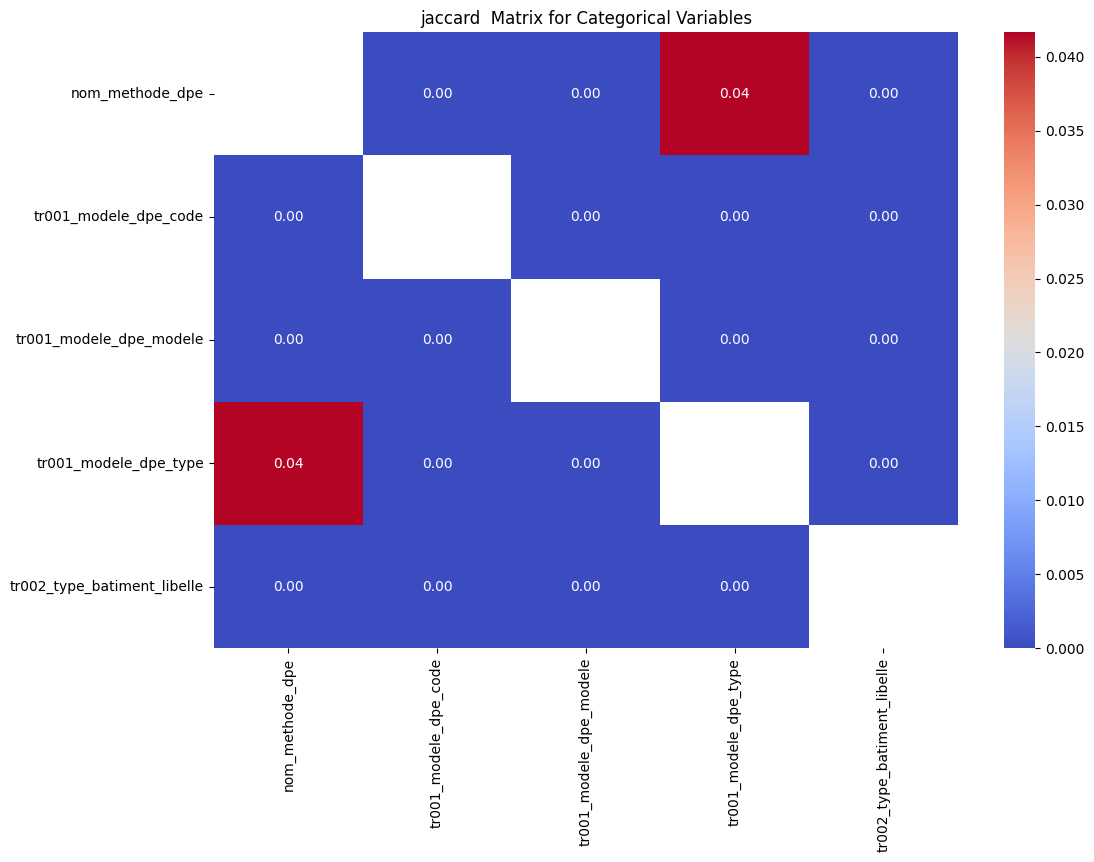

In [51]:
# Jaccard similarity for categorical columns detection de similarité entre les colonnes catégorielles

categorical_cols = categorical_df.columns
def jaccard_similarity(col1, col2):
    set1 = set(col1.dropna().unique())
    set2 = set(col2.dropna().unique())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

# Apply Jaccard similarity to categorical columns
jaccard_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            jaccard_matrix.loc[col1, col2] = jaccard_similarity(categorical_df[col1], categorical_df[col2])

jaccard_matrix = jaccard_matrix.astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('jaccard  Matrix for Categorical Variables')
plt.show()

### detection des outliers 

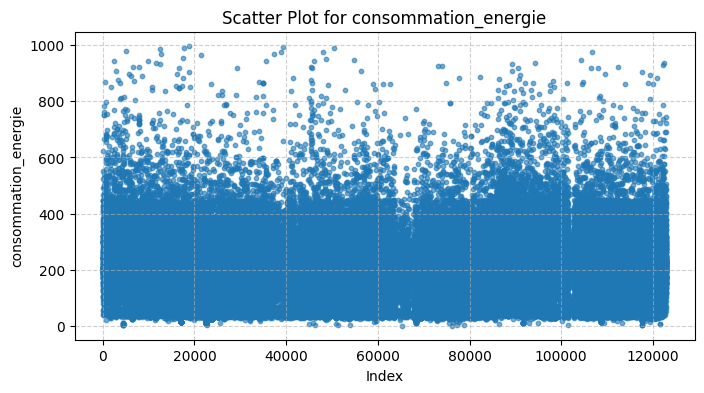

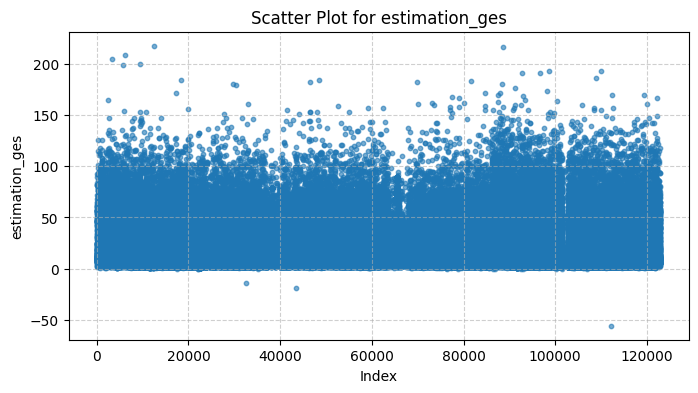

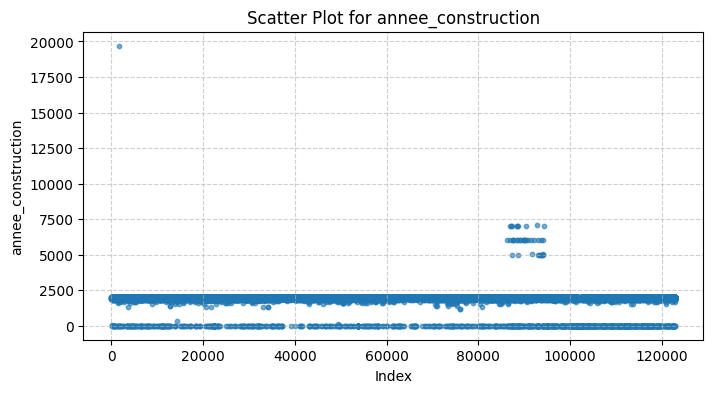

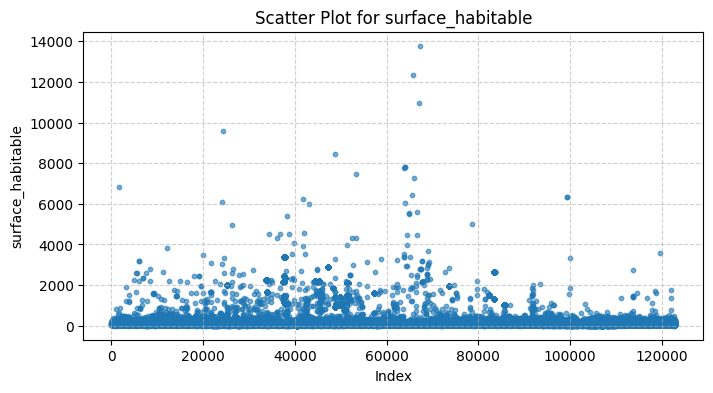

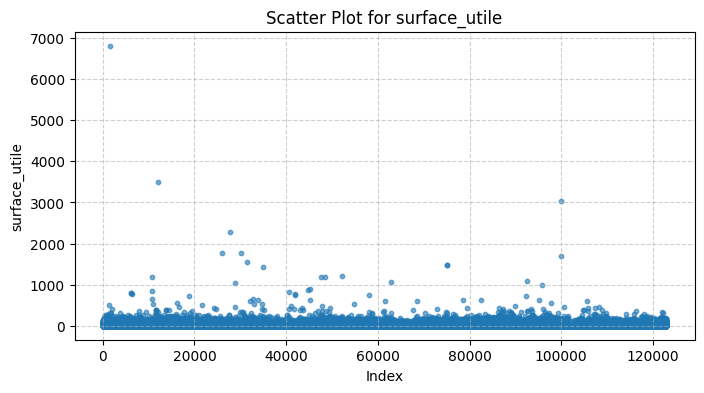

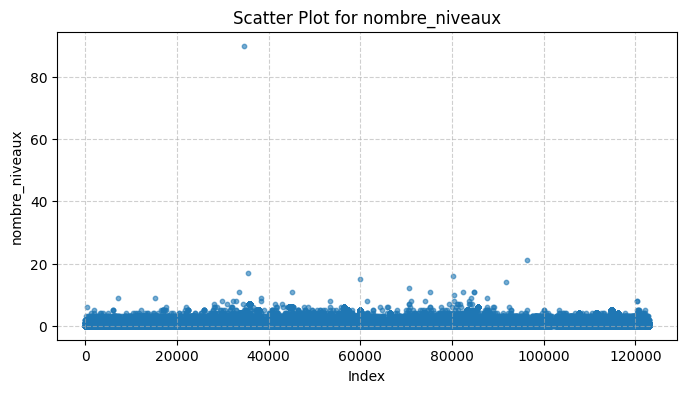

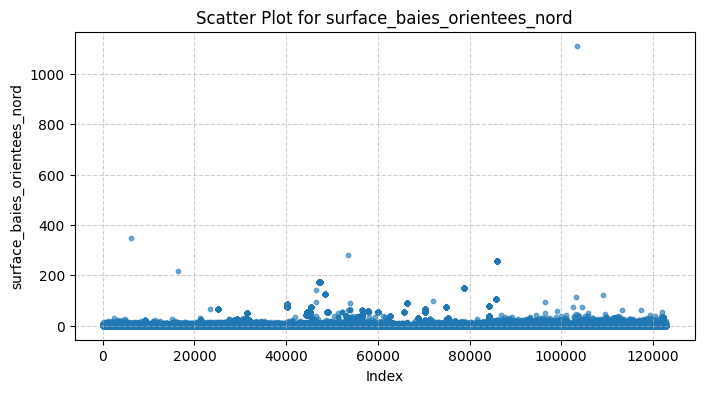

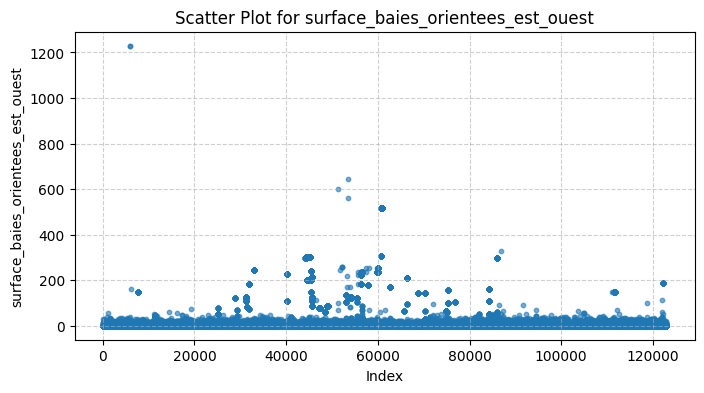

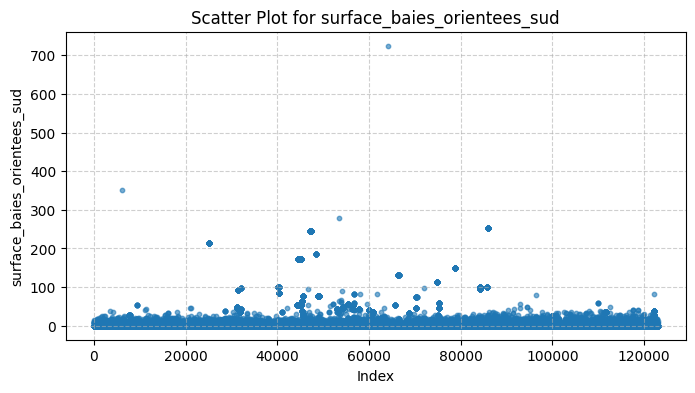

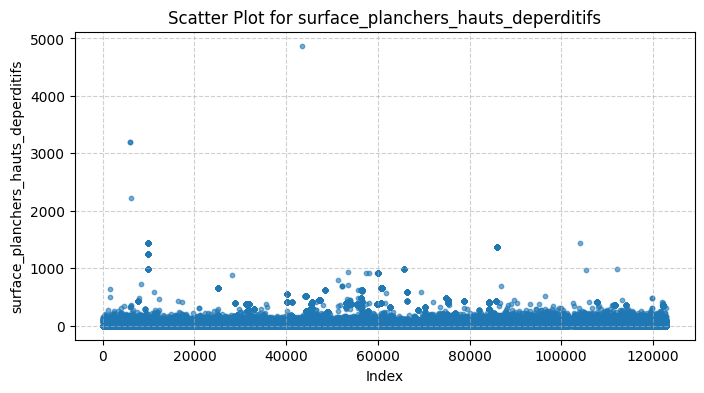

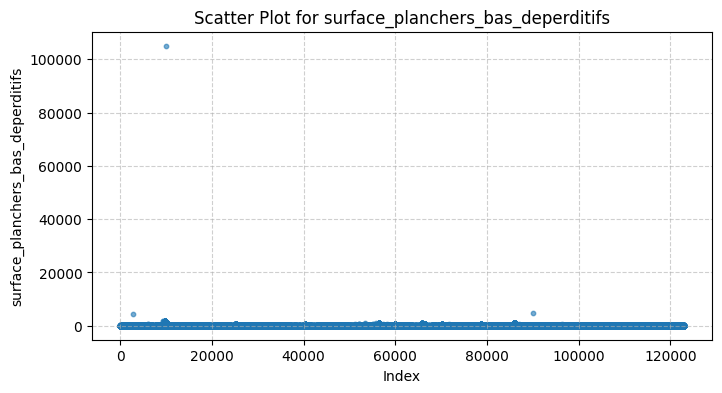

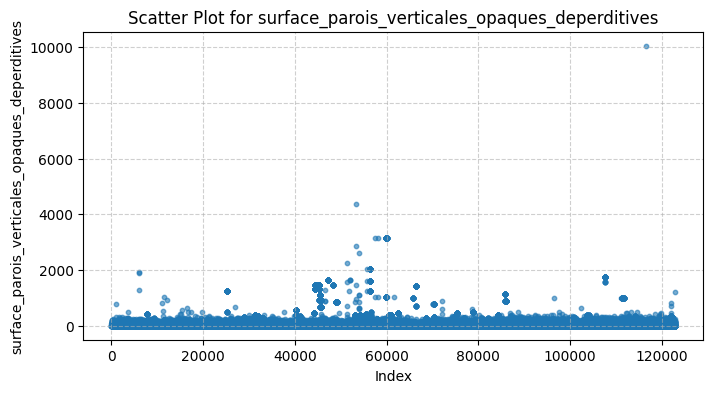

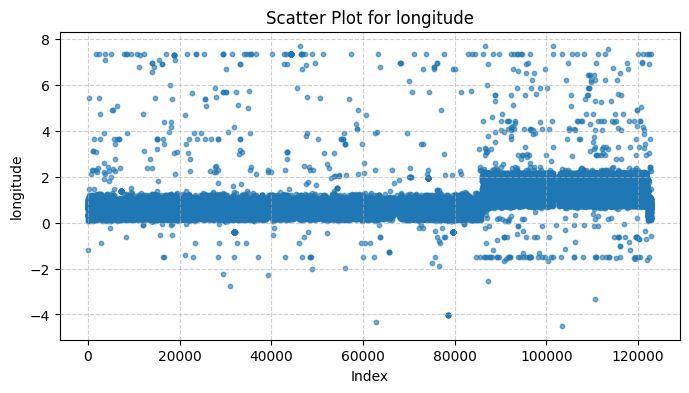

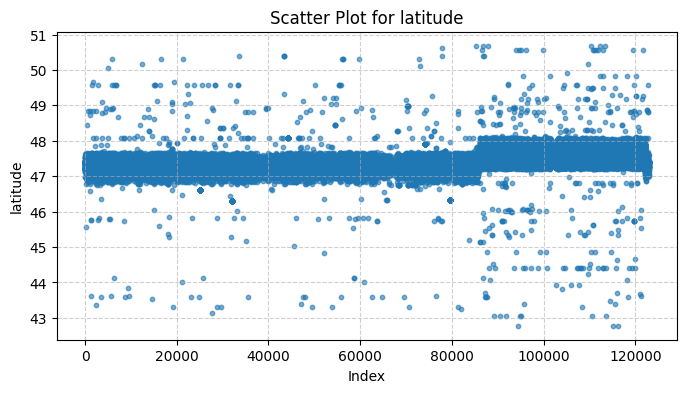

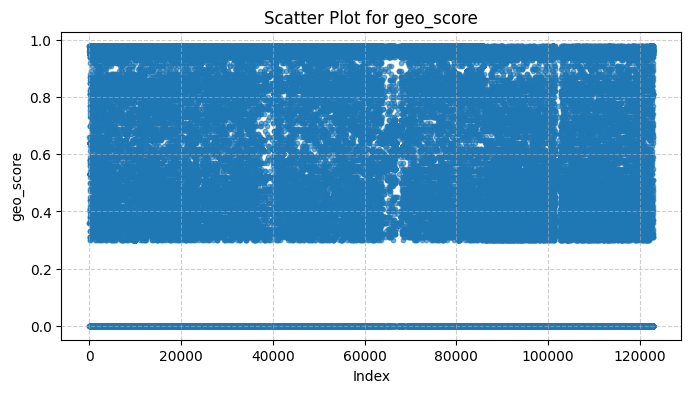

In [433]:
# Generate a scatter plot for each quantitative column
for column in quantitative_df.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(quantitative_df[column])), quantitative_df[column], alpha=0.6, s=10)
    plt.title(f"Scatter Plot for {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

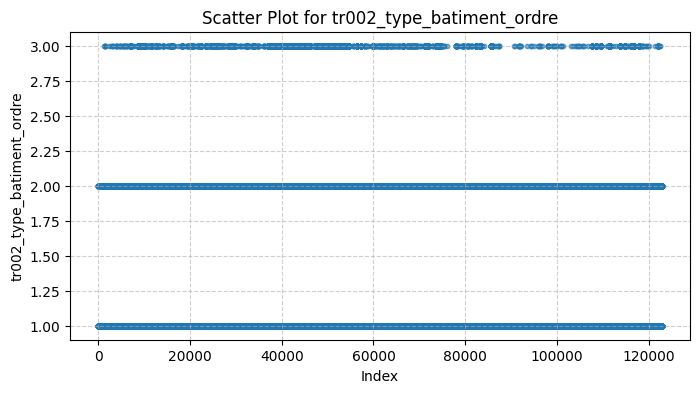

In [434]:
# Generate a scatter plot for each quantitative column
for column in qualitative_df.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(qualitative_df[column])), qualitative_df[column], alpha=0.6, s=10)
    plt.title(f"Scatter Plot for {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

### outliers isolation

In [435]:
import scipy.stats as stats

# remove outliers from quantitative_df and qualitative_df
def remove_outliers(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on the Z-score.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): The list of columns to check for outliers.
        threshold (int): The Z-score threshold for detecting outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    z_scores = np.abs(stats.zscore(df[columns]))
    df = df[(z_scores < threshold).all(axis=1)]
    return df

In [436]:
quantitative_df1 = remove_outliers(quantitative_df, columns=['annee_construction'])

quantitative_df1

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score
0,201.00,8.00,1989,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00
1,209.64,9.71,2001,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00
5,278.63,13.89,1974,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96
125467,151.22,35.38,1982,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96
125468,377.00,12.00,1947,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55


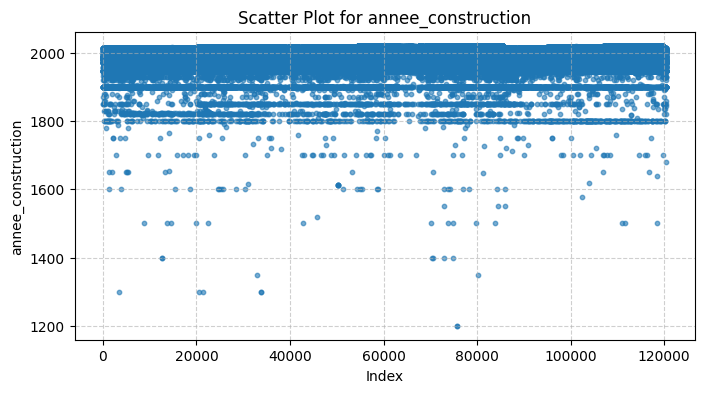

In [437]:
plt.figure(figsize=(8, 4))
plt.scatter(range(len(quantitative_df1['annee_construction'])), quantitative_df1['annee_construction'], alpha=0.6, s=10)
plt.title("Scatter Plot for annee_construction")
plt.xlabel("Index")
plt.ylabel("annee_construction")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

1. merged data after first process

In [438]:
merged_data = pd.concat([quantitative_df1, qualitative_df, categorical_df], axis=1)

In [439]:
merged_data

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr002_type_batiment_ordre,nom_methode_dpe,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,201.00,8.00,1989.0,58.53,0.0,1.0,5.26,0.0,5.84,0.0,0.0,52.66,NaN,NaN,0.00,2,Méthode 3CL,V1,6.1,Vente,Appartement
1,209.64,9.71,2001.0,130.00,130.0,1.0,0.00,0.0,0.00,0.0,0.0,0.00,0.838555,47.539634,0.36,1,TROIS_CL_DPE,V1,6.1,Vente,Maison
2,177.12,5.77,1900.0,43.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.696860,47.389350,0.98,2,3CL - DPE,L2,6.B,Location,Appartement
3,234.04,54.76,1900.0,93.00,93.0,1.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,0.00,1,FACTURE,V2,6.2,Vente,Maison
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96,1,3CL - DPE,V1,6.1,Vente,Maison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Méthode Facture,L2,6.B,Location,Appartement
125268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,L2,6.B,Location,Appartement
125376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,I2,6.2 (Vente),Copropriété,Appartement
125459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,I2,6.2 (Vente),Copropriété,Appartement


In [440]:
# Charger le dataset
dfTest = merged_data

# Calculer le pourcentage de valeurs manquantes pour chaque ligne
missing_percentage = dfTest.isnull().sum(axis=1) / dfTest.shape[1] * 100

# Ajouter cette information dans le dataframe
dfTest["%_missing"] = missing_percentage

# Afficher les 10 premières lignes avec le pourcentage de valeurs manquantes
dfTest

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr002_type_batiment_ordre,nom_methode_dpe,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle,%_missing
0,201.00,8.00,1989.0,58.53,0.0,1.0,5.26,0.0,5.84,0.0,0.0,52.66,NaN,NaN,0.00,2,Méthode 3CL,V1,6.1,Vente,Appartement,9.523810
1,209.64,9.71,2001.0,130.00,130.0,1.0,0.00,0.0,0.00,0.0,0.0,0.00,0.838555,47.539634,0.36,1,TROIS_CL_DPE,V1,6.1,Vente,Maison,0.000000
2,177.12,5.77,1900.0,43.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.696860,47.389350,0.98,2,3CL - DPE,L2,6.B,Location,Appartement,0.000000
3,234.04,54.76,1900.0,93.00,93.0,1.0,0.00,0.0,0.00,0.0,0.0,0.00,NaN,NaN,0.00,1,FACTURE,V2,6.2,Vente,Maison,9.523810
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96,1,3CL - DPE,V1,6.1,Vente,Maison,38.095238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Méthode Facture,L2,6.B,Location,Appartement,71.428571
125268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,L2,6.B,Location,Appartement,71.428571
125376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,I2,6.2 (Vente),Copropriété,Appartement,71.428571
125459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Facture,I2,6.2 (Vente),Copropriété,Appartement,71.428571


In [441]:
# Définir le seuil de pourcentage de valeurs manquantes
seuil = 60

# Supprimer les lignes où le pourcentage de valeurs nulles est supérieur au seuil
df_cleaned = dfTest[dfTest["%_missing"] <= seuil]

df_cleaned = df_cleaned.drop(columns=["%_missing"])

In [442]:
df_cleaned

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude,geo_score,tr002_type_batiment_ordre,nom_methode_dpe,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,201.00,8.00,1989.0,58.53,0.0,1.0,5.26,0.0,5.84,0.00,0.00,52.66,NaN,NaN,0.00,2,Méthode 3CL,V1,6.1,Vente,Appartement
1,209.64,9.71,2001.0,130.00,130.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,0.838555,47.539634,0.36,1,TROIS_CL_DPE,V1,6.1,Vente,Maison
2,177.12,5.77,1900.0,43.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.696860,47.389350,0.98,2,3CL - DPE,L2,6.B,Location,Appartement
3,234.04,54.76,1900.0,93.00,93.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,1,FACTURE,V2,6.2,Vente,Maison
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96,1,3CL - DPE,V1,6.1,Vente,Maison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982.0,79.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,1,3CL - DPE,V1,6.1,Vente,Maison
125467,151.22,35.38,1982.0,98.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,1,3CL - DPE,V1,6.1,Vente,Maison
125468,377.00,12.00,1947.0,32.05,0.0,1.0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,NaN,0.00,2,Méthode Facture,L2,6.B,Location,Appartement
125469,273.00,16.00,1983.0,174.00,0.0,1.0,0.00,19.9,0.00,164.33,113.59,139.79,0.452953,47.024512,0.55,1,Méthode 3CL,V1,6.1,Vente,Maison


In [443]:
df = df_cleaned
# Classification des colonnes
quantitative_col = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_col = df.select_dtypes(include=['object']).columns.tolist()

# Identifier les colonnes qualitatives (variables ordinales ou discrètes non continues)
# Ici, on prend les colonnes numériques qui sont susceptibles d'être des catégories ordinales
qualitative_col = []

# Exemple de règles pour les identifier (basé sur le nombre de valeurs uniques)
for col in quantitative_col:
    if df[col].nunique() < 15:  # Si une variable numérique a peu de valeurs distinctes, elle est probablement qualitative
        qualitative_col.append(col)

# Retirer les qualitatives de la liste des quantitatives
quantitative_col = [col for col in quantitative_col if col not in qualitative_col]

# Affichage des catégories
classification = {
    "Quantitative Columns": quantitative_col,
    "Qualitative Columns": qualitative_col,
    "Categorical Columns": categorical_col
}

# Affichage sous forme de tableau pour faciliter la lecture
classification_df = pd.DataFrame([(k, ", ".join(v)) for k, v in classification.items()], columns=["Type", "Columns"])

# Diviser le DataFrame en trois sous-ensembles en fonction de la classification
quantitative_df = df[quantitative_col]
qualitative_df = df[qualitative_col]
categorical_df = df[categorical_col]

2. etude de correlation entre variables de chaque data set

Highly Correlated Columns: ['surface_baies_orientees_sud', 'surface_planchers_hauts_deperditifs', 'surface_parois_verticales_opaques_deperditives']


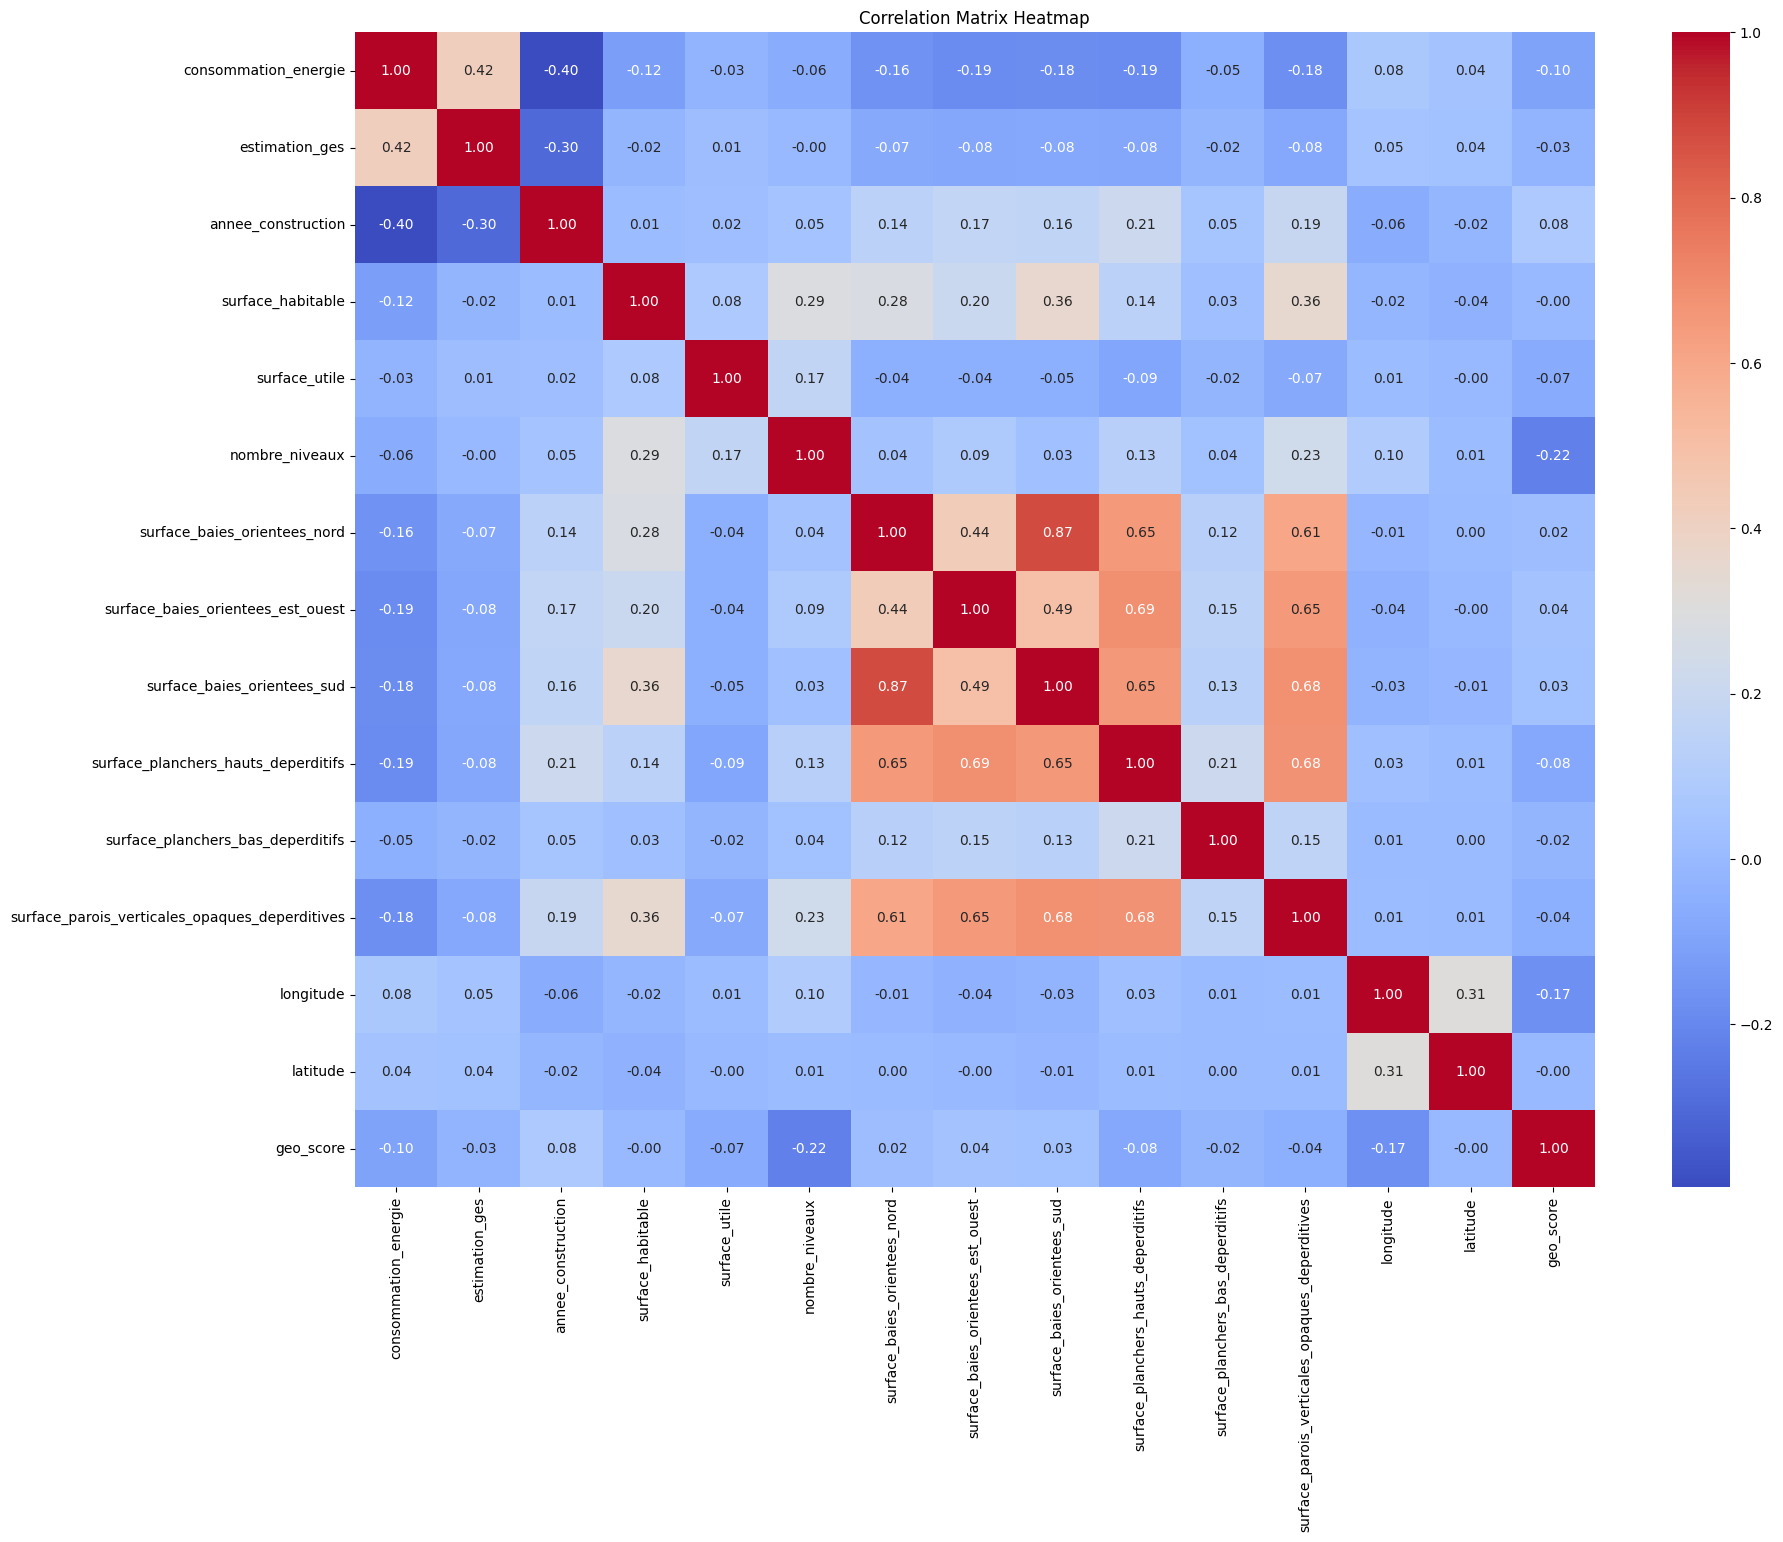

In [444]:
# Correlation matrix
corr_matrix = quantitative_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than 0.67
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.67)]
print(f"Highly Correlated Columns: {high_corr_cols}")

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [445]:
# Drop highly correlated columns
quantitative_df = quantitative_df.drop(columns=high_corr_cols)
print(f"Qualitative df shape after dropping highly correlated columns: {quantitative_df.shape}")

Qualitative df shape after dropping highly correlated columns: (120490, 12)


In [446]:
quantitative_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,surface_utile,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989.0,58.53,0.0,1.0,5.26,0.0,0.00,NaN,NaN,0.00
1,209.64,9.71,2001.0,130.00,130.0,1.0,0.00,0.0,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900.0,43.00,0.0,0.0,0.00,0.0,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900.0,93.00,93.0,1.0,0.00,0.0,0.00,NaN,NaN,0.00
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982.0,79.00,NaN,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96
125467,151.22,35.38,1982.0,98.00,NaN,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96
125468,377.00,12.00,1947.0,32.05,0.0,1.0,0.00,0.0,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983.0,174.00,0.0,1.0,0.00,19.9,113.59,0.452953,47.024512,0.55


In [447]:
# manque de données dans les colonnes surface_utile par rapport à surface_habitable
# drop surface_utile 
quantitative_df = quantitative_df.drop(columns='surface_utile')

In [448]:
quantitative_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989.0,58.53,1.0,5.26,0.0,0.00,NaN,NaN,0.00
1,209.64,9.71,2001.0,130.00,1.0,0.00,0.0,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900.0,43.00,0.0,0.00,0.0,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900.0,93.00,1.0,0.00,0.0,0.00,NaN,NaN,0.00
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982.0,79.00,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96
125467,151.22,35.38,1982.0,98.00,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96
125468,377.00,12.00,1947.0,32.05,1.0,0.00,0.0,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983.0,174.00,1.0,0.00,19.9,113.59,0.452953,47.024512,0.55


3. cramers correlation pour categorical df

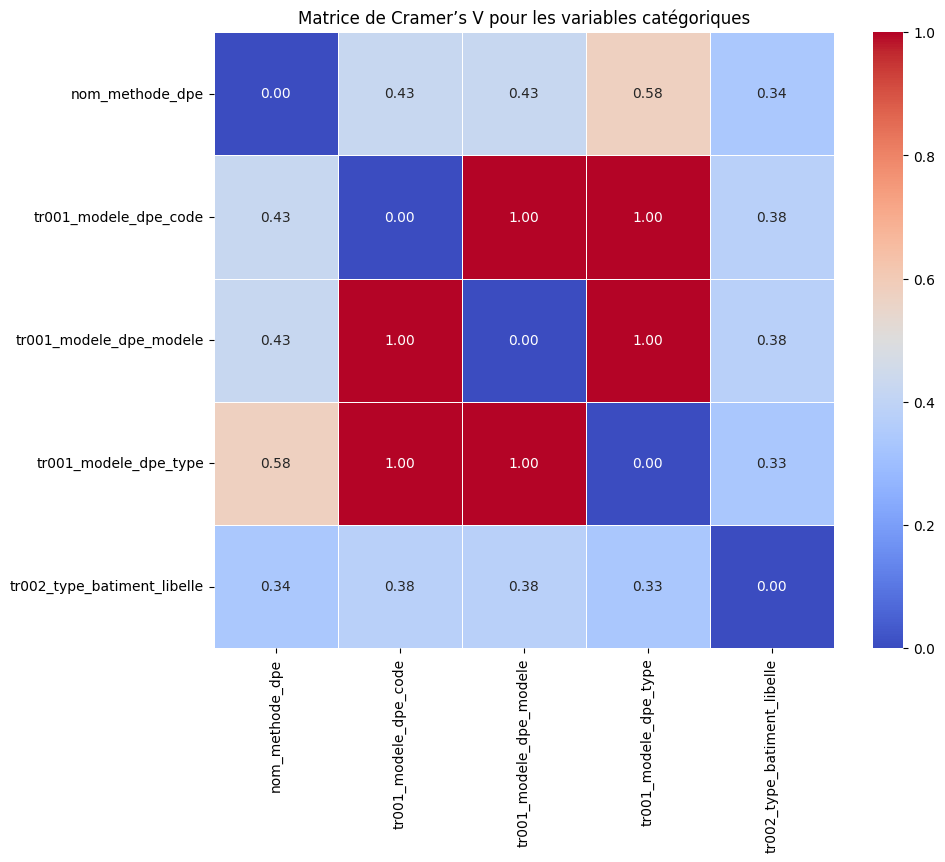

In [449]:
# Fonction pour calculer Cramer's V
categorical_columns = categorical_df.columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# Matrice de Cramer’s V
n = len(categorical_columns)
cramers_matrix = pd.DataFrame(np.zeros((n, n)), columns=categorical_columns, index=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            confusion_matrix = pd.crosstab(categorical_df[col1], categorical_df[col2])
            cramers_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Heatmap pour visualiser les corrélations
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de Cramer’s V pour les variables catégoriques")
plt.show()

In [450]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_code,tr001_modele_dpe_modele,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,Méthode 3CL,V1,6.1,Vente,Appartement
1,TROIS_CL_DPE,V1,6.1,Vente,Maison
2,3CL - DPE,L2,6.B,Location,Appartement
3,FACTURE,V2,6.2,Vente,Maison
5,3CL - DPE,V1,6.1,Vente,Maison
...,...,...,...,...,...
125466,3CL - DPE,V1,6.1,Vente,Maison
125467,3CL - DPE,V1,6.1,Vente,Maison
125468,Méthode Facture,L2,6.B,Location,Appartement
125469,Méthode 3CL,V1,6.1,Vente,Maison


In [451]:
coll_rem = ['tr001_modele_dpe_code','tr001_modele_dpe_modele']

In [452]:
categorical_df = categorical_df.drop(columns=coll_rem)

In [453]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,Méthode 3CL,Vente,Appartement
1,TROIS_CL_DPE,Vente,Maison
2,3CL - DPE,Location,Appartement
3,FACTURE,Vente,Maison
5,3CL - DPE,Vente,Maison
...,...,...,...
125466,3CL - DPE,Vente,Maison
125467,3CL - DPE,Vente,Maison
125468,Méthode Facture,Location,Appartement
125469,Méthode 3CL,Vente,Maison


In [454]:
# Afficher toutes les valeurs uniques et leur fréquence pour la colonne 'nom_methode_dpe'
method_counts = categorical_df["nom_methode_dpe"].value_counts()

print(f"Unique Values for 'nom_methode_dpe': {method_counts}")

Unique Values for 'nom_methode_dpe': nom_methode_dpe
3CL - DPE                           43819
Méthode 3CL                         23156
FACTURE - DPE                       21237
Méthode Facture                     10388
TROIS_CL_DPE                         6782
3CL-DPE                              3966
FACTURE                              3632
Th-BCE                               1998
3CL                                  1276
facture                              1225
th-CE                                 894
TH_C_E                                445
Factures                              425
FACTURE SEULE                         421
TH_BCE                                342
Facture                               208
MIXTE FACTURE+3CL - DPE pour ECS      105
Neuf                                   94
Th-C-E                                 76
Facture - DPE                           1
Name: count, dtype: int64


In [455]:
# Dictionnaire de correspondance pour fusionner les valeurs similaires
correction_methode_dpe = {
    "3CL - DPE": "3CL - DPE",
    "3CL-DPE": "3CL - DPE",
    "TROIS_CL_DPE": "3CL - DPE",
    "3CL": "3CL - DPE",
    "Méthode 3CL": "3CL - DPE",
    
    "FACTURE - DPE": "Facture - DPE",
    "Méthode Facture": "Facture - DPE",
    "FACTURE": "Facture - DPE",
    "facture": "Facture - DPE",
    "Factures": "Facture - DPE",
    "FACTURE SEULE": "Facture - DPE",
    "Facture": "Facture - DPE",
    
    "TH_C_E": "Th-C-E",
    "th-CE": "Th-C-E",
    "Th-C-E": "Th-C-E",
    
    "TH_BCE": "Th-BCE",
    "th-BCE": "Th-BCE",
    
    "MIXTE FACTURE+3CL - DPE pour ECS": "Mixte Facture + 3CL - DPE",
    "Neuf": "Neuf"
}

# Appliquer la correction sur la colonne nom_methode_dpe
categorical_df["nom_methode_dpe"] = categorical_df["nom_methode_dpe"].replace(correction_methode_dpe)

# Vérifier la correction des valeurs uniques
method_counts = categorical_df["nom_methode_dpe"].value_counts().reset_index()
method_counts.columns = ["nom_methode_dpe", "nombre_occurrences"]

In [456]:
# Afficher toutes les valeurs uniques et leur fréquence pour la colonne 'nom_methode_dpe' apres correction
method_counts = categorical_df["nom_methode_dpe"].value_counts()

print(f"Unique Values for 'nom_methode_dpe': {method_counts}")

Unique Values for 'nom_methode_dpe': nom_methode_dpe
3CL - DPE                    78999
Facture - DPE                37537
Th-BCE                        2340
Th-C-E                        1415
Mixte Facture + 3CL - DPE      105
Neuf                            94
Name: count, dtype: int64


In [457]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,3CL - DPE,Vente,Appartement
1,3CL - DPE,Vente,Maison
2,3CL - DPE,Location,Appartement
3,Facture - DPE,Vente,Maison
5,3CL - DPE,Vente,Maison
...,...,...,...
125466,3CL - DPE,Vente,Maison
125467,3CL - DPE,Vente,Maison
125468,Facture - DPE,Location,Appartement
125469,3CL - DPE,Vente,Maison


In [458]:
merged_df = pd.concat([quantitative_df, qualitative_df, categorical_df], axis=1)

In [459]:
merged_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score,tr002_type_batiment_ordre,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,201.00,8.00,1989.0,58.53,1.0,5.26,0.0,0.00,NaN,NaN,0.00,2,3CL - DPE,Vente,Appartement
1,209.64,9.71,2001.0,130.00,1.0,0.00,0.0,0.00,0.838555,47.539634,0.36,1,3CL - DPE,Vente,Maison
2,177.12,5.77,1900.0,43.00,0.0,0.00,0.0,0.00,0.696860,47.389350,0.98,2,3CL - DPE,Location,Appartement
3,234.04,54.76,1900.0,93.00,1.0,0.00,0.0,0.00,NaN,NaN,0.00,1,Facture - DPE,Vente,Maison
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96,1,3CL - DPE,Vente,Maison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982.0,79.00,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96,1,3CL - DPE,Vente,Maison
125467,151.22,35.38,1982.0,98.00,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96,1,3CL - DPE,Vente,Maison
125468,377.00,12.00,1947.0,32.05,1.0,0.00,0.0,0.00,NaN,NaN,0.00,2,Facture - DPE,Location,Appartement
125469,273.00,16.00,1983.0,174.00,1.0,0.00,19.9,113.59,0.452953,47.024512,0.55,1,3CL - DPE,Vente,Maison


In [460]:
df_cleaned = merged_df
# Classification des colonnes
quantitative_col = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_col = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Identifier les colonnes qualitatives (variables ordinales ou discrètes non continues)
# Ici, on prend les colonnes numériques qui sont susceptibles d'être des catégories ordinales
qualitative_col = []

# Exemple de règles pour les identifier (basé sur le nombre de valeurs uniques)
for col in quantitative_col:
    if df_cleaned[col].nunique() < 15:  # Si une variable numérique a peu de valeurs distinctes, elle est probablement qualitative
        qualitative_col.append(col)

# Retirer les qualitatives de la liste des quantitatives
quantitative_col = [col for col in quantitative_col if col not in qualitative_col]

# Affichage des catégories
classification = {
    "Quantitative Columns": quantitative_col,
    "Qualitative Columns": qualitative_col,
    "Categorical Columns": categorical_col
}

# Affichage sous forme de tableau pour faciliter la lecture
classification_df = pd.DataFrame([(k, ", ".join(v)) for k, v in classification.items()], columns=["Type", "Columns"])

# Diviser le DataFrame en trois sous-ensembles en fonction de la classification
quantitative_df = df_cleaned[quantitative_col]
qualitative_df = df_cleaned[qualitative_col]
categorical_df = df_cleaned[categorical_col]

In [461]:
quantitative_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989.0,58.53,1.0,5.26,0.0,0.00,NaN,NaN,0.00
1,209.64,9.71,2001.0,130.00,1.0,0.00,0.0,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900.0,43.00,0.0,0.00,0.0,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900.0,93.00,1.0,0.00,0.0,0.00,NaN,NaN,0.00
5,278.63,13.89,1974.0,128.89,NaN,NaN,NaN,NaN,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982.0,79.00,NaN,NaN,NaN,NaN,0.624554,47.274189,0.96
125467,151.22,35.38,1982.0,98.00,NaN,NaN,NaN,NaN,0.894629,47.594574,0.96
125468,377.00,12.00,1947.0,32.05,1.0,0.00,0.0,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983.0,174.00,1.0,0.00,19.9,113.59,0.452953,47.024512,0.55


In [462]:
# Change the data type of 'annee_construction' to int
quantitative_df['annee_construction'] = quantitative_df['annee_construction'].astype(int)

C:\Users\tarek\AppData\Local\Temp\ipykernel_8856\3384457930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantitative_df['annee_construction'] = quantitative_df['annee_construction'].astype(int)


In [463]:
# Change the data type of 'annee_construction' to int
qualitative_df['tr002_type_batiment_ordre'] = qualitative_df['tr002_type_batiment_ordre'].astype(int)

C:\Users\tarek\AppData\Local\Temp\ipykernel_8856\2360447278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualitative_df['tr002_type_batiment_ordre'] = qualitative_df['tr002_type_batiment_ordre'].astype(int)


In [464]:
qualitative_df

,tr002_type_batiment_ordre
0,2
1,1
2,2
3,1
5,1
...,...
125466,1
125467,1
125468,2
125469,1


In [465]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,3CL - DPE,Vente,Appartement
1,3CL - DPE,Vente,Maison
2,3CL - DPE,Location,Appartement
3,Facture - DPE,Vente,Maison
5,3CL - DPE,Vente,Maison
...,...,...,...
125466,3CL - DPE,Vente,Maison
125467,3CL - DPE,Vente,Maison
125468,Facture - DPE,Location,Appartement
125469,3CL - DPE,Vente,Maison


In [466]:
# Détecter les colonnes avec des valeurs nulles
null_columns = df_cleaned.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
nombre_niveaux                       33628
surface_baies_orientees_nord         34885
surface_baies_orientees_est_ouest    34885
surface_planchers_bas_deperditifs    34885
longitude                            13128
latitude                             13128
dtype: int64


In [ ]:
# Filtrer les lignes où la colonne 'surface_planchers_bas_deperditifs' n'a pas de valeur null
df_non_null = quantitative_df[quantitative_df['surface_planchers_bas_deperditifs'].notnull()]

# Afficher le DataFrame filtré
df_non_null

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989,58.53,1.0,5.26,0.00,0.00,NaN,NaN,0.00
1,209.64,9.71,2001,130.00,1.0,0.00,0.00,0.00,0.838555,47.539634,0.36
2,177.12,5.77,1900,43.00,0.0,0.00,0.00,0.00,0.696860,47.389350,0.98
3,234.04,54.76,1900,93.00,1.0,0.00,0.00,0.00,NaN,NaN,0.00
7,361.30,65.00,1960,71.00,1.0,0.00,0.00,0.00,0.671289,47.410345,0.66
...,...,...,...,...,...,...,...,...,...,...,...
125464,231.68,7.54,1930,157.81,0.0,0.00,0.00,0.00,0.926292,46.992562,0.94
125465,194.00,7.00,2006,39.90,1.0,0.00,5.77,39.00,NaN,NaN,0.00
125468,377.00,12.00,1947,32.05,1.0,0.00,0.00,0.00,NaN,NaN,0.00
125469,273.00,16.00,1983,174.00,1.0,0.00,19.90,113.59,0.452953,47.024512,0.55


In [467]:
surface_to_list=['surface_baies_orientees_est_ouest','surface_baies_orientees_nord']

In [468]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Supposons que df_cleaned soit ton dataframe
df = quantitative_df.copy()

# Séparer les lignes avec et sans valeurs manquantes
df_not_null = df[df["surface_planchers_bas_deperditifs"].notnull()]
df_null = df[df["surface_planchers_bas_deperditifs"].isnull()]

columns=['surface_baies_orientees_est_ouest','surface_baies_orientees_nord']


X_train = df_not_null[columns]
y_train = df_not_null["surface_planchers_bas_deperditifs"]

X_missing = df_null[columns]  # Lignes où la cible est manquante

# Imputer les valeurs manquantes des features (ex : médiane)
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=('surface_baies_orientees_est_ouest','surface_baies_orientees_nord'))
X_missing = pd.DataFrame(imputer.transform(X_missing), columns=('surface_baies_orientees_est_ouest','surface_baies_orientees_nord'))

# Initialiser et entraîner le modèle de régression linéaire
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Prédire les valeurs manquantes
predictions = reg_model.predict(X_missing)

# Remplacer les valeurs nulles par les prédictions
df.loc[df["surface_planchers_bas_deperditifs"].isnull(), "surface_planchers_bas_deperditifs"] = predictions

print("✅ Imputation terminée avec une régression linéaire.")


✅ Imputation terminée avec une régression linéaire.


In [469]:
df 


,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989,58.53,1.0,5.26,0.0,0.000000,NaN,NaN,0.00
1,209.64,9.71,2001,130.00,1.0,0.00,0.0,0.000000,0.838555,47.539634,0.36
2,177.12,5.77,1900,43.00,0.0,0.00,0.0,0.000000,0.696860,47.389350,0.98
3,234.04,54.76,1900,93.00,1.0,0.00,0.0,0.000000,NaN,NaN,0.00
5,278.63,13.89,1974,128.89,NaN,NaN,NaN,26.009948,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982,79.00,NaN,NaN,NaN,26.009948,0.624554,47.274189,0.96
125467,151.22,35.38,1982,98.00,NaN,NaN,NaN,26.009948,0.894629,47.594574,0.96
125468,377.00,12.00,1947,32.05,1.0,0.00,0.0,0.000000,NaN,NaN,0.00
125469,273.00,16.00,1983,174.00,1.0,0.00,19.9,113.590000,0.452953,47.024512,0.55


In [470]:
# Détecter les colonnes avec des valeurs nulles
null_columns = df.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
nombre_niveaux                       33628
surface_baies_orientees_nord         34885
surface_baies_orientees_est_ouest    34885
longitude                            13128
latitude                             13128
dtype: int64


In [471]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# essayer regression linear pour les valeurs manquantes , "Lasso" ou "Ridge" regression
# imputer surface_planchers_bas_deperditifs avec une regression lasso 


# 1. Médiane pour les valeurs continues
median_imputer = SimpleImputer(strategy="median")
#quantitative_df[["surface_planchers_bas_deperditifs"]] = median_imputer.fit_transform(df_cleaned[["surface_planchers_bas_deperditifs"]])

# 2. Mode (valeur la plus fréquente) pour les valeurs discrètes
mode_imputer = SimpleImputer(strategy="most_frequent")
df[["nombre_niveaux"]] = mode_imputer.fit_transform(df[["nombre_niveaux"]])

# 3. Valeur 0 pour les surfaces des baies vitrées si elles sont souvent nulles
if (df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] == 0).sum().sum() > len(df) * 0.5:
    df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] = df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]].fillna(0)
else:
    df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]] = median_imputer.fit_transform(df[["surface_baies_orientees_nord", "surface_baies_orientees_est_ouest"]])

# 4. KNN Imputer pour les coordonnées géographiques (longitude, latitude, geo_score)
knn_imputer = KNNImputer(n_neighbors=3)
df[["longitude", "latitude"]] = knn_imputer.fit_transform(df[["longitude", "latitude"]])

In [472]:
# Détecter les colonnes avec des valeurs nulles
null_columns = df.isnull().sum()

# Filtrer les colonnes qui contiennent des valeurs nulles
columns_with_nulls = null_columns[null_columns > 0]

# Afficher les colonnes avec des valeurs nulles et leur nombre
print("Colonnes avec des valeurs nulles :")
print(columns_with_nulls)

Colonnes avec des valeurs nulles :
Series([], dtype: int64)


# Correlation avec la variable cible

### Quantitative with pearson

In [473]:
def compute_correlations(df, target_variable):
    """
    Computes the correlation between each column in a DataFrame and the target variable.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the target variable.
        target_variable (str): The column name of the target variable.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Feature', 'Correlation', 'P-Value'].
    """
    if target_variable not in df.columns:
        raise ValueError(f"Target variable '{target_variable}' is not in the DataFrame.")

    correlations = []
    for column in df.columns:
        if column == target_variable:
            continue

        if np.issubdtype(df[column].dtype, np.number):  # Numeric column
            try:
                corr, p_value = pearsonr(df[column].dropna(), df[target_variable].dropna())
            except Exception as e:
                corr, p_value = np.nan, np.nan  # Handle cases where correlation can't be computed
        else:  # Non-numeric column
            corr, p_value = np.nan, np.nan  # Extend with categorical correlation techniques if needed

        correlations.append({'Feature': column, 'Correlation': corr, 'P-Value': p_value})

    # Convert to DataFrame
    correlation_df = pd.DataFrame(correlations)
    correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)

    return correlation_df

correlation_numeric = compute_correlations(df, 'consommation_energie')

In [474]:
correlation_numeric

,Feature,Correlation,P-Value
0,estimation_ges,0.420590,0.000000e+00
3,nombre_niveaux,0.093484,5.414840e-232
7,longitude,0.071857,1.149556e-137
8,latitude,0.038474,1.040092e-40
6,surface_planchers_bas_deperditifs,-0.033092,1.484835e-30
4,surface_baies_orientees_nord,-0.087645,4.622523e-204
9,geo_score,-0.097788,9.493460e-254
5,surface_baies_orientees_est_ouest,-0.110890,0.000000e+00
2,surface_habitable,-0.117403,0.000000e+00
1,annee_construction,-0.397159,0.000000e+00


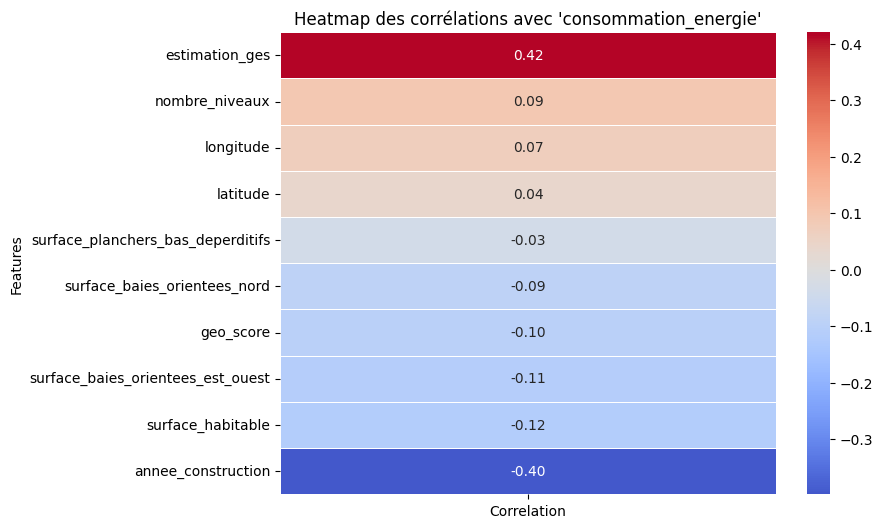

In [475]:
# Correction de la heatmap en utilisant les bonnes colonnes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_numeric.set_index('Feature')[['Correlation']], 
            annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)

plt.title("Heatmap des corrélations avec 'consommation_energie'")
plt.ylabel("Features")
plt.show()

### Categoriel

In [476]:
def compute_categorical_correlations(df, numeric_series):
    """
    Computes the correlation between each categorical column in the DataFrame
    and the target numeric series using appropriate statistical tests.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing categorical columns.
        numeric_series (pd.Series): The numeric series to test correlation against.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Feature', 'Correlation Type', 'Statistic', 'P-Value'].
    """
    if len(df) != len(numeric_series):
        raise ValueError("The length of the numeric series must match the number of rows in the DataFrame.")

    correlations = []

    for column in df.columns:
        if df[column].dtype == 'object' or np.issubdtype(df[column].dtype, np.integer):
            # If the column is categorical
            if df[column].nunique() > 2:  # Multi-class categorical variable
                # Use ANOVA for multi-class categorical vs numeric
                groups = [numeric_series[df[column] == category] for category in df[column].unique()]
                try:
                    stat, p_value = f_oneway(*groups)
                    correlation_type = 'ANOVA'
                except Exception as e:
                    stat, p_value, correlation_type = np.nan, np.nan, 'ANOVA Failed'
            else:  # Binary categorical variable
                # Use Chi-squared test for binary categorical vs numeric
                contingency_table = pd.crosstab(df[column], numeric_series.round())
                try:
                    stat, p_value, _, _ = chi2_contingency(contingency_table)
                    correlation_type = 'Chi-Squared'
                except Exception as e:
                    stat, p_value, correlation_type = np.nan, np.nan, 'Chi-Squared Failed'

            correlations.append({
                'Feature': column,
                'Correlation Type': correlation_type,
                'Statistic': stat,
                'P-Value': p_value
            })

    correlation_df = pd.DataFrame(correlations)
    correlation_df.sort_values(by='P-Value', ascending=True, inplace=True)

    return correlation_df

In [477]:
compute_categorical_correlations(categorical_df, quantitative_df['consommation_energie'])

,Feature,Correlation Type,Statistic,P-Value
0,nom_methode_dpe,ANOVA,3967.008024,0.0
1,tr001_modele_dpe_type,ANOVA,16052.626270,0.0
2,tr002_type_batiment_libelle,ANOVA,2441.799907,0.0


In [478]:
compute_categorical_correlations(qualitative_df, quantitative_df['consommation_energie'])

,Feature,Correlation Type,Statistic,P-Value
0,tr002_type_batiment_ordre,ANOVA,2441.799907,0.0


In [481]:
merged_data = pd.concat([df,categorical_df], axis=1)

In [482]:
merged_data

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,201.00,8.00,1989,58.53,1.0,5.26,0.0,0.000000,0.874818,47.411432,0.00,3CL - DPE,Vente,Appartement
1,209.64,9.71,2001,130.00,1.0,0.00,0.0,0.000000,0.838555,47.539634,0.36,3CL - DPE,Vente,Maison
2,177.12,5.77,1900,43.00,0.0,0.00,0.0,0.000000,0.696860,47.389350,0.98,3CL - DPE,Location,Appartement
3,234.04,54.76,1900,93.00,1.0,0.00,0.0,0.000000,0.874818,47.411432,0.00,Facture - DPE,Vente,Maison
5,278.63,13.89,1974,128.89,0.0,0.00,0.0,26.009948,0.713967,47.391239,0.96,3CL - DPE,Vente,Maison
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982,79.00,0.0,0.00,0.0,26.009948,0.624554,47.274189,0.96,3CL - DPE,Vente,Maison
125467,151.22,35.38,1982,98.00,0.0,0.00,0.0,26.009948,0.894629,47.594574,0.96,3CL - DPE,Vente,Maison
125468,377.00,12.00,1947,32.05,1.0,0.00,0.0,0.000000,0.874818,47.411432,0.00,Facture - DPE,Location,Appartement
125469,273.00,16.00,1983,174.00,1.0,0.00,19.9,113.590000,0.452953,47.024512,0.55,3CL - DPE,Vente,Maison


In [483]:

# Classification des colonnes
quantitative_col = merged_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_col = merged_data.select_dtypes(include=['object']).columns.tolist()

# Identifier les colonnes qualitatives (variables ordinales ou discrètes non continues)
# Ici, on prend les colonnes numériques qui sont susceptibles d'être des catégories ordinales
qualitative_col = []

# Exemple de règles pour les identifier (basé sur le nombre de valeurs uniques)
for col in quantitative_col:
    if merged_data[col].nunique() < 15:  # Si une variable numérique a peu de valeurs distinctes, elle est probablement qualitative
        qualitative_col.append(col)

# Retirer les qualitatives de la liste des quantitatives
quantitative_col = [col for col in quantitative_col if col not in qualitative_col]

# Affichage des catégories
classification = {
    "Quantitative Columns": quantitative_col,
    "Qualitative Columns": qualitative_col,
    "Categorical Columns": categorical_col
}

# Affichage sous forme de tableau pour faciliter la lecture
classification_df = pd.DataFrame([(k, ", ".join(v)) for k, v in classification.items()], columns=["Type", "Columns"])

# Diviser le DataFrame en trois sous-ensembles en fonction de la classification
quantitative_df = merged_data[quantitative_col]
qualitative_df = merged_data[qualitative_col]
categorical_df = merged_data[categorical_col]


In [484]:
# Change the data type of 'annee_construction' to int
quantitative_df['annee_construction'] = quantitative_df['annee_construction'].astype(int)

C:\Users\tarek\AppData\Local\Temp\ipykernel_8856\3384457930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantitative_df['annee_construction'] = quantitative_df['annee_construction'].astype(int)


In [485]:
quantitative_df

,consommation_energie,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score
0,201.00,8.00,1989,58.53,1.0,5.26,0.0,0.000000,0.874818,47.411432,0.00
1,209.64,9.71,2001,130.00,1.0,0.00,0.0,0.000000,0.838555,47.539634,0.36
2,177.12,5.77,1900,43.00,0.0,0.00,0.0,0.000000,0.696860,47.389350,0.98
3,234.04,54.76,1900,93.00,1.0,0.00,0.0,0.000000,0.874818,47.411432,0.00
5,278.63,13.89,1974,128.89,0.0,0.00,0.0,26.009948,0.713967,47.391239,0.96
...,...,...,...,...,...,...,...,...,...,...,...
125466,275.81,14.49,1982,79.00,0.0,0.00,0.0,26.009948,0.624554,47.274189,0.96
125467,151.22,35.38,1982,98.00,0.0,0.00,0.0,26.009948,0.894629,47.594574,0.96
125468,377.00,12.00,1947,32.05,1.0,0.00,0.0,0.000000,0.874818,47.411432,0.00
125469,273.00,16.00,1983,174.00,1.0,0.00,19.9,113.590000,0.452953,47.024512,0.55


In [486]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,3CL - DPE,Vente,Appartement
1,3CL - DPE,Vente,Maison
2,3CL - DPE,Location,Appartement
3,Facture - DPE,Vente,Maison
5,3CL - DPE,Vente,Maison
...,...,...,...
125466,3CL - DPE,Vente,Maison
125467,3CL - DPE,Vente,Maison
125468,Facture - DPE,Location,Appartement
125469,3CL - DPE,Vente,Maison


# Normalisation

### Normalisation quantitative

In [308]:
merged_data.to_excel('merged_data_to_normalize.xlsx', index=False)

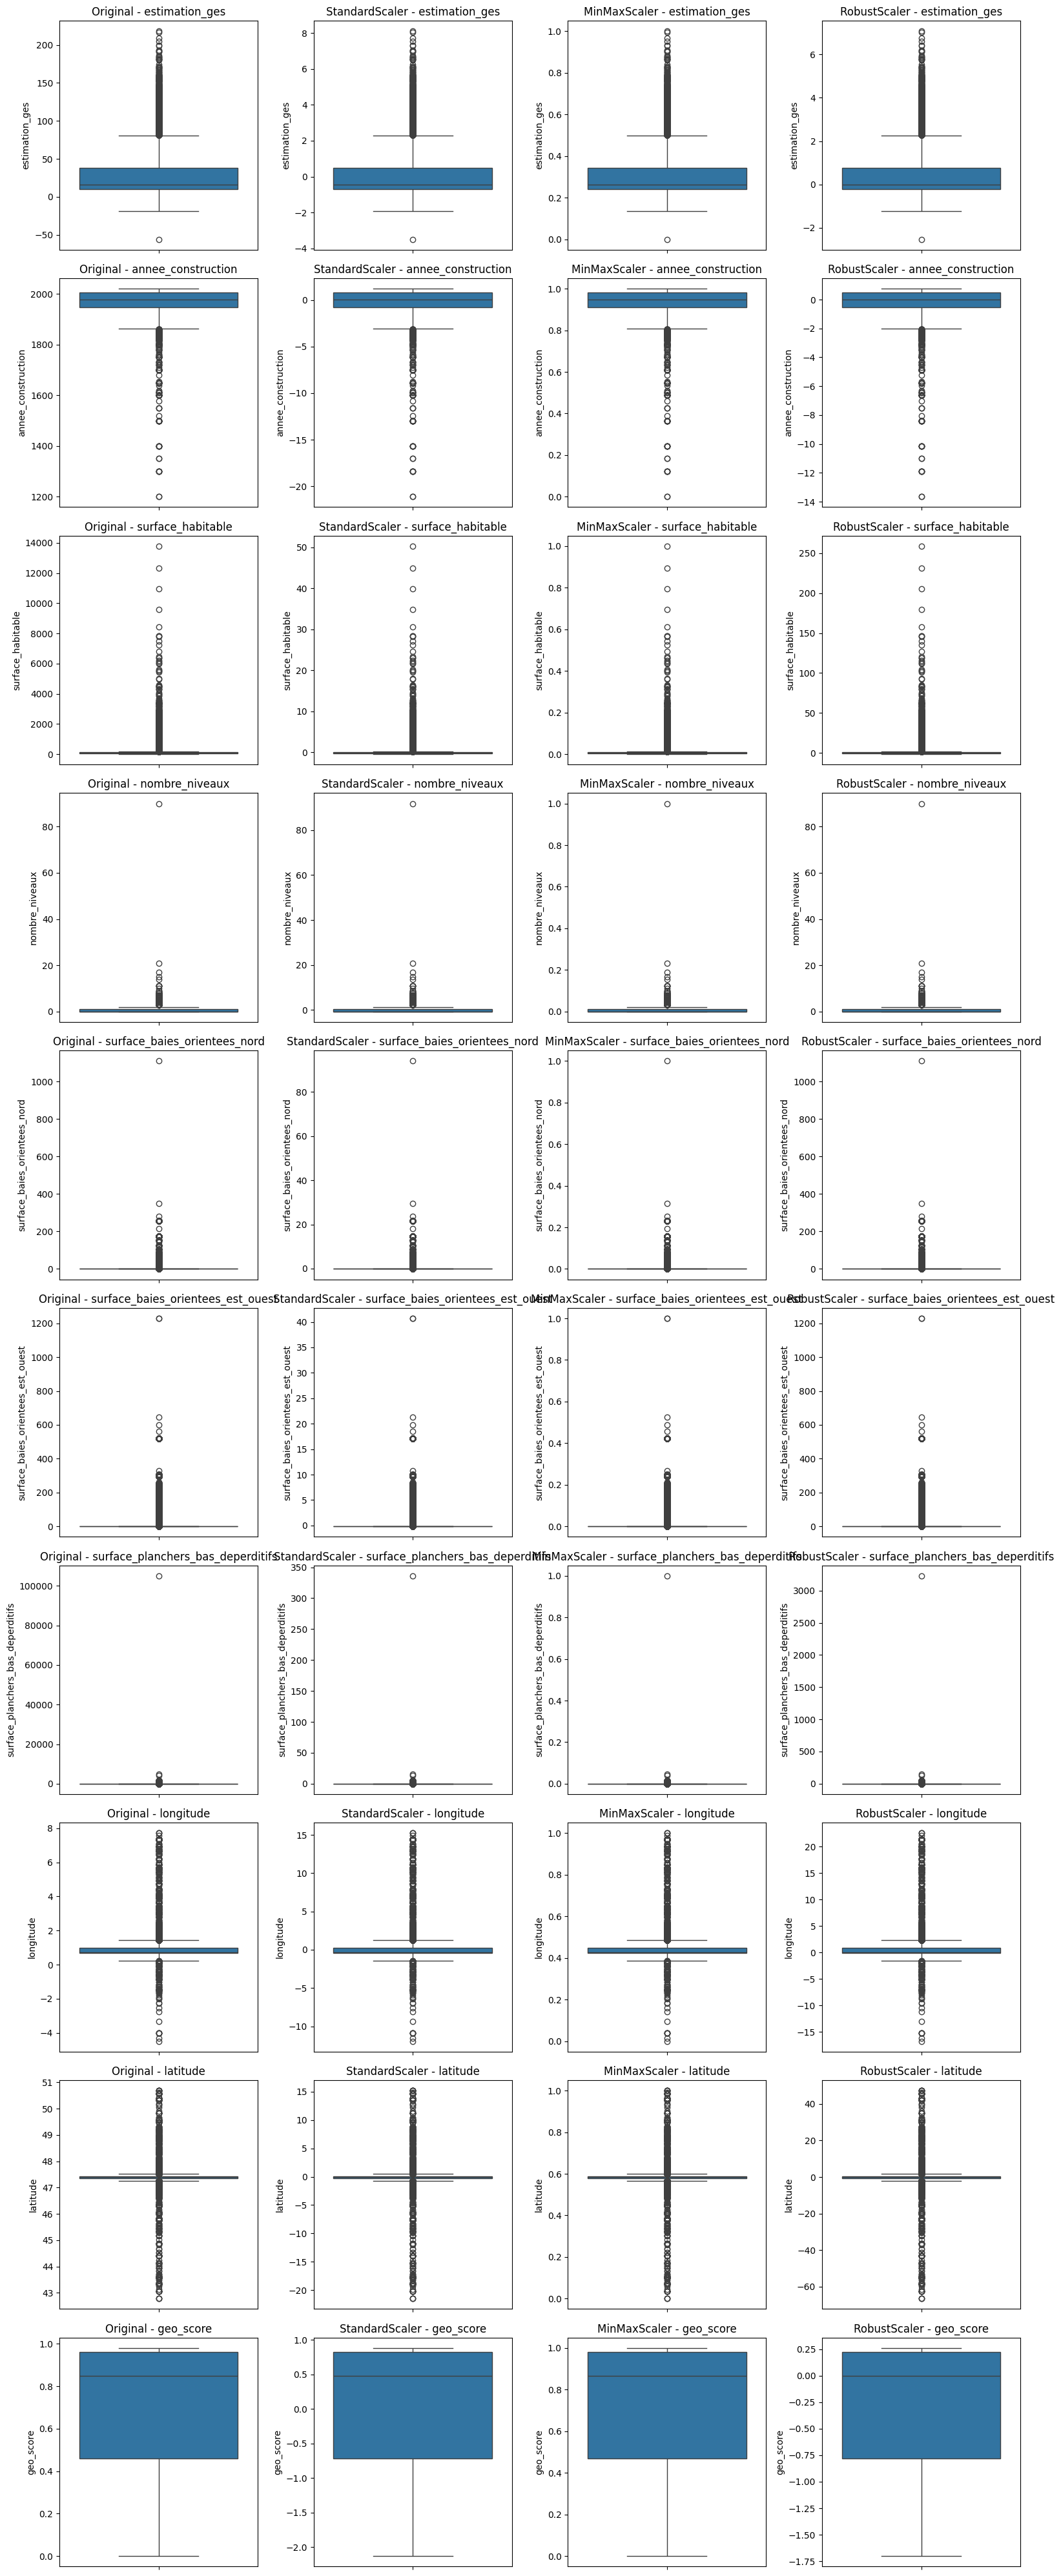

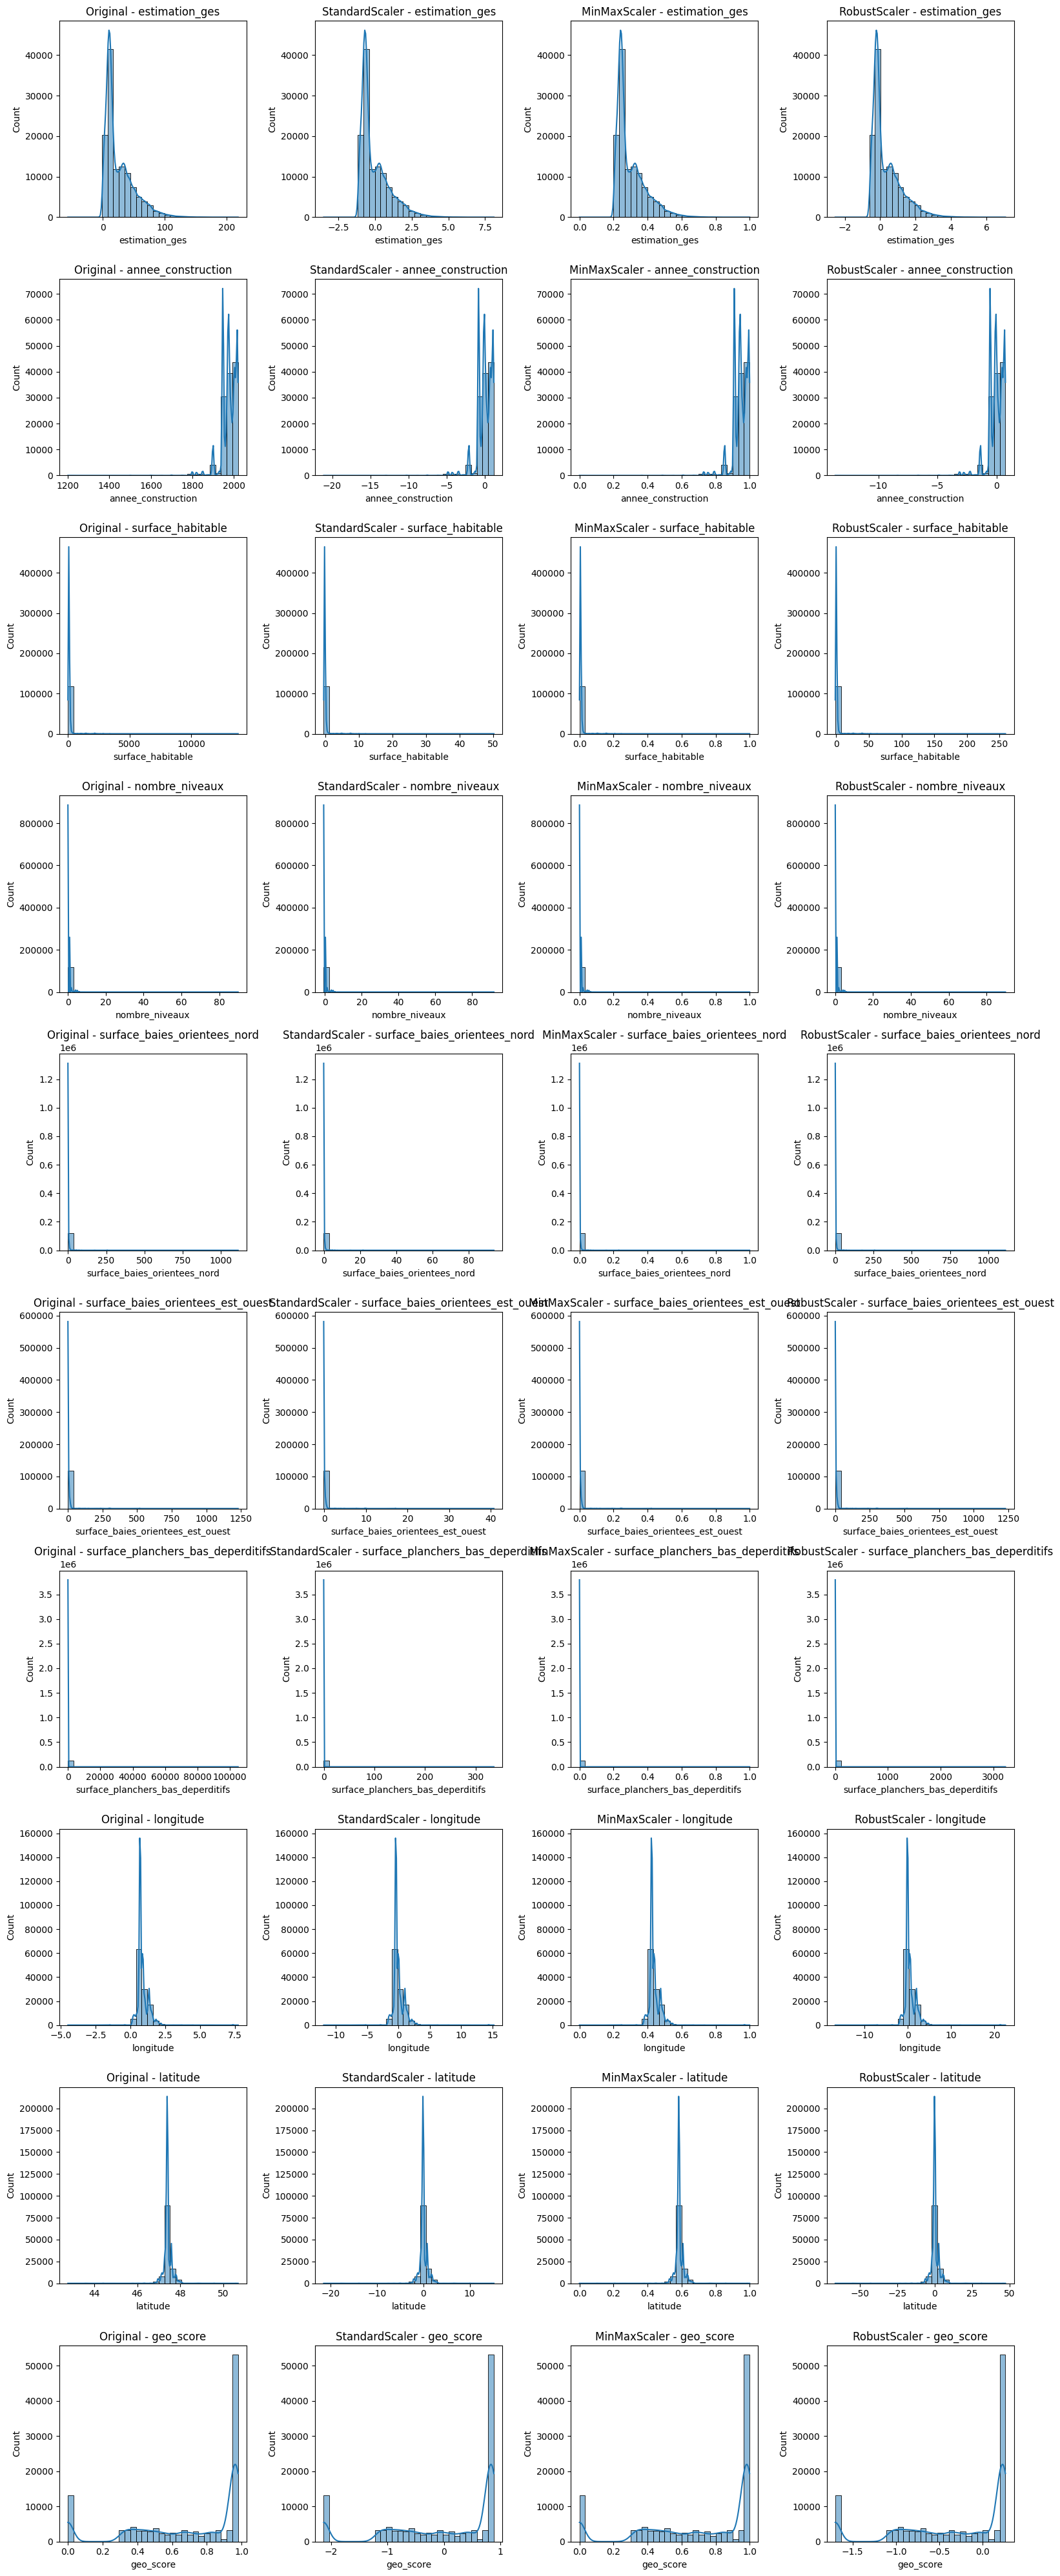

In [487]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pandas as pd

# Identifier la variable cible
target_col = "consommation_energie"

# Séparer les features et la cible
X_quantitative = quantitative_df.drop(columns=[target_col])
y_target = quantitative_df[target_col]  # Ne pas normaliser la cible

# Appliquer les normalisations
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Dictionnaire pour stocker les résultats
scaled_dfs = {}

for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_quantitative)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_quantitative.columns, index=quantitative_df.index)
    X_scaled_df[target_col] = y_target  # Ajouter la variable cible
    scaled_dfs[name] = X_scaled_df

# Comparaison des distributions avec boxplots
fig, axes = plt.subplots(nrows=len(X_quantitative.columns), ncols=4, figsize=(16, 4 * len(X_quantitative.columns)))

for i, col in enumerate(X_quantitative.columns):
    # Boxplot de la distribution originale
    sns.boxplot(y=quantitative_df[col], ax=axes[i, 0])
    axes[i, 0].set_title(f"Original - {col}")

    # Boxplot StandardScaler
    sns.boxplot(y=scaled_dfs["StandardScaler"][col], ax=axes[i, 1])
    axes[i, 1].set_title(f"StandardScaler - {col}")

    # Boxplot MinMaxScaler
    sns.boxplot(y=scaled_dfs["MinMaxScaler"][col], ax=axes[i, 2])
    axes[i, 2].set_title(f"MinMaxScaler - {col}")

    # Boxplot RobustScaler
    sns.boxplot(y=scaled_dfs["RobustScaler"][col], ax=axes[i, 3])
    axes[i, 3].set_title(f"RobustScaler - {col}")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

# Comparaison des distributions avec histogrammes
fig, axes = plt.subplots(nrows=len(X_quantitative.columns), ncols=4, figsize=(16, 4 * len(X_quantitative.columns)))

for i, col in enumerate(X_quantitative.columns):
    # Histogramme de la distribution originale
    sns.histplot(quantitative_df[col], ax=axes[i, 0], kde=True, bins=30)
    axes[i, 0].set_title(f"Original - {col}")

    # Histogramme StandardScaler
    sns.histplot(scaled_dfs["StandardScaler"][col], ax=axes[i, 1], kde=True, bins=30)
    axes[i, 1].set_title(f"StandardScaler - {col}")

    # Histogramme MinMaxScaler
    sns.histplot(scaled_dfs["MinMaxScaler"][col], ax=axes[i, 2], kde=True, bins=30)
    axes[i, 2].set_title(f"MinMaxScaler - {col}")

    # Histogramme RobustScaler
    sns.histplot(scaled_dfs["RobustScaler"][col], ax=axes[i, 3], kde=True, bins=30)
    axes[i, 3].set_title(f"RobustScaler - {col}")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()

In [488]:
X_scaled_df = pd.concat([scaled_dfs['MinMaxScaler']])

In [489]:
X_scaled_df

,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score,consommation_energie
0,0.233508,0.961023,0.004246,0.011111,0.004734,0.000000,0.000000,0.439567,0.586022,0.000000,201.00
1,0.239748,0.975639,0.009431,0.011111,0.000000,0.000000,0.000000,0.436595,0.602239,0.367347,209.64
2,0.225372,0.852619,0.003120,0.000000,0.000000,0.000000,0.000000,0.424984,0.583229,1.000000,177.12
3,0.404116,0.852619,0.006747,0.011111,0.000000,0.000000,0.000000,0.439567,0.586022,0.000000,234.04
5,0.254999,0.942753,0.009351,0.000000,0.000000,0.000000,0.000247,0.426386,0.583468,0.979592,278.63
...,...,...,...,...,...,...,...,...,...,...,...
125466,0.257188,0.952497,0.005731,0.000000,0.000000,0.000000,0.000247,0.419059,0.568661,0.979592,275.81
125467,0.333406,0.952497,0.007110,0.000000,0.000000,0.000000,0.000247,0.441190,0.609188,0.979592,151.22
125468,0.248103,0.909866,0.002325,0.011111,0.000000,0.000000,0.000000,0.439567,0.586022,0.000000,377.00
125469,0.262697,0.953715,0.012623,0.011111,0.000000,0.016184,0.001081,0.404997,0.537079,0.561224,273.00


In [490]:
categorical_df

,nom_methode_dpe,tr001_modele_dpe_type,tr002_type_batiment_libelle
0,3CL - DPE,Vente,Appartement
1,3CL - DPE,Vente,Maison
2,3CL - DPE,Location,Appartement
3,Facture - DPE,Vente,Maison
5,3CL - DPE,Vente,Maison
...,...,...,...
125466,3CL - DPE,Vente,Maison
125467,3CL - DPE,Vente,Maison
125468,Facture - DPE,Location,Appartement
125469,3CL - DPE,Vente,Maison


In [491]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Identifier les colonnes catégorielles avec peu de catégories (pour One-Hot Encoding)
one_hot_cols = [col for col in categorical_df.columns if categorical_df[col].nunique() <= 10]

# Appliquer One-Hot Encoding en gardant toutes les catégories
one_hot_encoder = OneHotEncoder(drop=None, sparse_output=False)
encoded_one_hot = one_hot_encoder.fit_transform(categorical_df[one_hot_cols])
encoded_one_hot_df = pd.DataFrame(encoded_one_hot, columns=one_hot_encoder.get_feature_names_out(one_hot_cols))

# S'assurer que l'index est aligné
encoded_one_hot_df.index = categorical_df.index  

# Identifier les colonnes restantes pour Label Encoding
label_cols = [col for col in categorical_df.columns if col not in one_hot_cols]

# Appliquer Label Encoding sur les autres colonnes (avec un encodeur différent par colonne)
for col in label_cols:
    le = LabelEncoder()
    categorical_df[col] = le.fit_transform(categorical_df[col])

# Fusionner les données encodées
categorical_encoded_df = pd.concat([categorical_df, encoded_one_hot_df], axis=1).drop(columns=one_hot_cols)

# Sauvegarder le fichier
# categorical_encoded_df.to_excel("categorical_encoded.xlsx", index=False)

print("✅ Encodage terminé. Toutes les valeurs sont bien encodées.")


✅ Encodage terminé. Toutes les valeurs sont bien encodées.


In [492]:
categorical_encoded_df

,nom_methode_dpe_3CL - DPE,nom_methode_dpe_Facture - DPE,nom_methode_dpe_Mixte Facture + 3CL - DPE,nom_methode_dpe_Neuf,nom_methode_dpe_Th-BCE,nom_methode_dpe_Th-C-E,tr001_modele_dpe_type_Copropriété,tr001_modele_dpe_type_Location,tr001_modele_dpe_type_Neuf,tr001_modele_dpe_type_Public,tr001_modele_dpe_type_Vente,tr002_type_batiment_libelle_Appartement,tr002_type_batiment_libelle_Logements collectifs,tr002_type_batiment_libelle_Maison
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
125467,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
125468,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
125469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [493]:
import pandas as pd


# Fusionner les datasets sur l'index
merged_data = pd.concat([X_scaled_df,categorical_encoded_df], axis=1)

# Vérifier si tout est bien aligné
merged_data
print("✅ Fusion terminée. Fichier enregistré sous 'final_dataset.xlsx'.")

✅ Fusion terminée. Fichier enregistré sous 'final_dataset.xlsx'.


# Phase 3

In [323]:
merged_data = pd.read_csv('final_dataset.csv')

In [494]:
merged_data 

,estimation_ges,annee_construction,surface_habitable,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score,consommation_energie,nom_methode_dpe_3CL - DPE,nom_methode_dpe_Facture - DPE,nom_methode_dpe_Mixte Facture + 3CL - DPE,nom_methode_dpe_Neuf,nom_methode_dpe_Th-BCE,nom_methode_dpe_Th-C-E,tr001_modele_dpe_type_Copropriété,tr001_modele_dpe_type_Location,tr001_modele_dpe_type_Neuf,tr001_modele_dpe_type_Public,tr001_modele_dpe_type_Vente,tr002_type_batiment_libelle_Appartement,tr002_type_batiment_libelle_Logements collectifs,tr002_type_batiment_libelle_Maison
0,0.233508,0.961023,0.004246,0.011111,0.004734,0.000000,0.000000,0.439567,0.586022,0.000000,201.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.239748,0.975639,0.009431,0.011111,0.000000,0.000000,0.000000,0.436595,0.602239,0.367347,209.64,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.225372,0.852619,0.003120,0.000000,0.000000,0.000000,0.000000,0.424984,0.583229,1.000000,177.12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.404116,0.852619,0.006747,0.011111,0.000000,0.000000,0.000000,0.439567,0.586022,0.000000,234.04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.254999,0.942753,0.009351,0.000000,0.000000,0.000000,0.000247,0.426386,0.583468,0.979592,278.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,0.257188,0.952497,0.005731,0.000000,0.000000,0.000000,0.000247,0.419059,0.568661,0.979592,275.81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
125467,0.333406,0.952497,0.007110,0.000000,0.000000,0.000000,0.000247,0.441190,0.609188,0.979592,151.22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
125468,0.248103,0.909866,0.002325,0.011111,0.000000,0.000000,0.000000,0.439567,0.586022,0.000000,377.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
125469,0.262697,0.953715,0.012623,0.011111,0.000000,0.016184,0.001081,0.404997,0.537079,0.561224,273.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [495]:
# Définir la variable cible

#garder un lot de données pour la validation
target_col = "consommation_energie"

# Séparer X (features) et y (cible)
X = merged_data.drop(columns=[target_col])
y = merged_data[target_col]

# Vérifier la forme des données
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (120490, 24), y shape: (120490,)


In [496]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Étape 1 : Split en Train (70%), Validation (10%), et Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train+val, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% de 20% = 10%

print(f"Taille du jeu d'entraînement : {X_train.shape[0]}")
print(f"Taille du jeu de validation : {X_val.shape[0]}")
print(f"Taille du jeu de test : {X_test.shape[0]}")

Taille du jeu d'entraînement : 96392
Taille du jeu de validation : 12049
Taille du jeu de test : 12049


In [497]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting  # Activer HistGradientBoosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Étape 2 : Initialiser HistGradientBoostingRegressor
hgb_model = HistGradientBoostingRegressor(loss="squared_error", max_iter=500, learning_rate=0.1, random_state=42)

# Cross-validation sur Train
kf = KFold(n_splits=3, shuffle=True, random_state=42)
scores = cross_val_score(hgb_model, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² : {scores.mean():.2f}")

# Étape 3 : Entraînement final sur Train et Validation
hgb_model.fit(X_train, y_train)

# Évaluation sur Validation
y_pred_val = hgb_model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f"📊 Performance sur Validation : MAE={mae_val:.2f}, MSE={mse_val:.2f}, R²={r2_val:.2f}")

# Évaluation sur Test
y_pred_test = hgb_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"✅ Performance sur Test : MAE={mae_test:.2f}, MSE={mse_test:.2f}, R²={r2_test:.2f}")

C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


📊 Cross-Validation R² : 0.76
📊 Performance sur Validation : MAE=29.94, MSE=3175.47, R²=0.76
✅ Performance sur Test : MAE=29.70, MSE=3036.55, R²=0.77


In [328]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Étape 1 : Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 2 : Cross-Validation sur Train pour valider le modèle
kf = KFold(n_splits=3, shuffle=True, random_state=42)
lr_model = LinearRegression()

scores = cross_val_score(lr_model, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² : {scores.mean():.2f}")

# Étape 3 : Entraînement final et test sur X_test
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Évaluation finale
r2_final = r2_score(y_test, y_pred)
print(f"✅ Score R² final sur le test set : {r2_final:.2f}")

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Performance du modèle de régression linéaire :")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

📊 Cross-Validation R² : 0.42
✅ Score R² final sur le test set : 0.44
📊 Performance du modèle de régression linéaire :
MAE: 60.66, MSE: 7270.83, R²: 0.44


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Étape 1 : Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 2 : Cross-Validation sur Train pour valider le modèle
kf = KFold(n_splits=3, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(n_estimators=900, random_state=42)

scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')
print(f"📊 Cross-Validation R² : {scores.mean():.2f}")

# Étape 3 : Entraînement final et test sur X_test
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Évaluation finale
from sklearn.metrics import r2_score
r2_final = r2_score(y_test, y_pred)
print(f"✅ Score R² final sur le test set : {r2_final:.2f}")

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Performance du modèle :")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

📊 Cross-Validation R² : 0.77
✅ Score R² final sur le test set : 0.78
📊 Performance du modèle :
MAE: 25.07, MSE: 2787.97, R²: 0.78


In [498]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialiser XGBoost
xgb_model = XGBRegressor(n_estimators=900, max_depth=14, learning_rate=0.1, random_state=42)

# Entraîner le modèle
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"✅ Performance du modèle XGBoost :")
print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

✅ Performance du modèle XGBoost :
MAE: 25.38, MSE: 2803.23, R²: 0.79


In [426]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialiser XGBoost
xgb_model = XGBRegressor(n_estimators=900, max_depth=14, learning_rate=0.1, random_state=42)

# Entraîner le modèle
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"✅ Performance du modèle XGBoost :")
print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

✅ Performance du modèle XGBoost :
MAE: 14.54, MSE: 1083.60, R²: 0.88


In [429]:
# Prédiction sur les données de test
y_pred_rf = xgb_model.predict(X_test)

# Comparer les prédictions avec les vraies valeurs
import pandas as pd

test_results = pd.DataFrame({
    "Valeur Réelle": y_test,
    "Prédiction": y_pred_rf
})

# Afficher les premières lignes
print(test_results.head(10))

# Sauvegarder pour analyse
test_results.to_excel("test_results.xlsx", index=False)

       Valeur Réelle  Prédiction
2617          417.01  338.638062
34812         227.75  252.632721
70277          55.34   58.448780
48244         168.93  163.571884
29813         108.32  110.761047
2960          111.22  111.205200
78695         210.95  215.353790
42263         224.43  245.352081
83422         235.44  271.996460
18867          37.16   38.508240


In [430]:
# Prédiction sur les données de test
y_pred_rf = rf_model.predict(X_test)

# Comparer les prédictions avec les vraies valeurs
import pandas as pd

test_results = pd.DataFrame({
    "Valeur Réelle": y_test,
    "Prédiction": y_pred_rf
})

# Afficher les premières lignes
print(test_results.head(10))

# Sauvegarder pour analyse
test_results.to_excel("test_results.xlsx", index=False)

       Valeur Réelle  Prédiction
2617          417.01  304.473371
34812         227.75  251.848557
70277          55.34   57.521786
48244         168.93  166.194471
29813         108.32  129.195671
2960          111.22  111.721471
78695         210.95  211.653971
42263         224.43  230.339329
83422         235.44  272.630229
18867          37.16   38.221857


In [434]:
# 📌 Calculer les métriques
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n📊 Performance du modèle {model_name} :")
    print(f"✅ MAE  : {mae:.2f}")
    print(f"✅ MSE  : {mse:.2f}")
    print(f"✅ RMSE : {rmse:.2f}")
    print(f"✅ R²   : {r2:.2f}")

# 📌 Évaluation des modèles
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Comparer les R²
if r2_score(y_test, y_pred_xgb) > r2_score(y_test, y_pred_rf):
    print("\n🚀 XGBoost est le meilleur modèle !")
else:
    print("\n🚀 Random Forest est le meilleur modèle !")


📊 Performance du modèle Random Forest :
✅ MAE  : 14.70
✅ MSE  : 1101.55
✅ RMSE : 33.19
✅ R²   : 0.88

📊 Performance du modèle XGBoost :
✅ MAE  : 14.54
✅ MSE  : 1083.60
✅ RMSE : 32.92
✅ R²   : 0.88

🚀 XGBoost est le meilleur modèle !


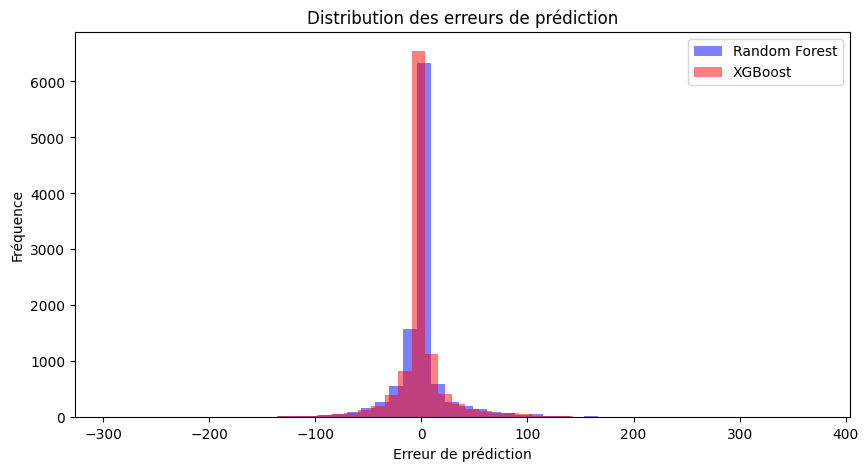

In [431]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Différences entre vraies valeurs et prédictions
error_rf = y_test - y_pred_rf
error_xgb = y_test - y_pred_xgb

plt.hist(error_rf, bins=50, alpha=0.5, label="Random Forest", color="blue")
plt.hist(error_xgb, bins=50, alpha=0.5, label="XGBoost", color="red")

plt.legend()
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
plt.show()


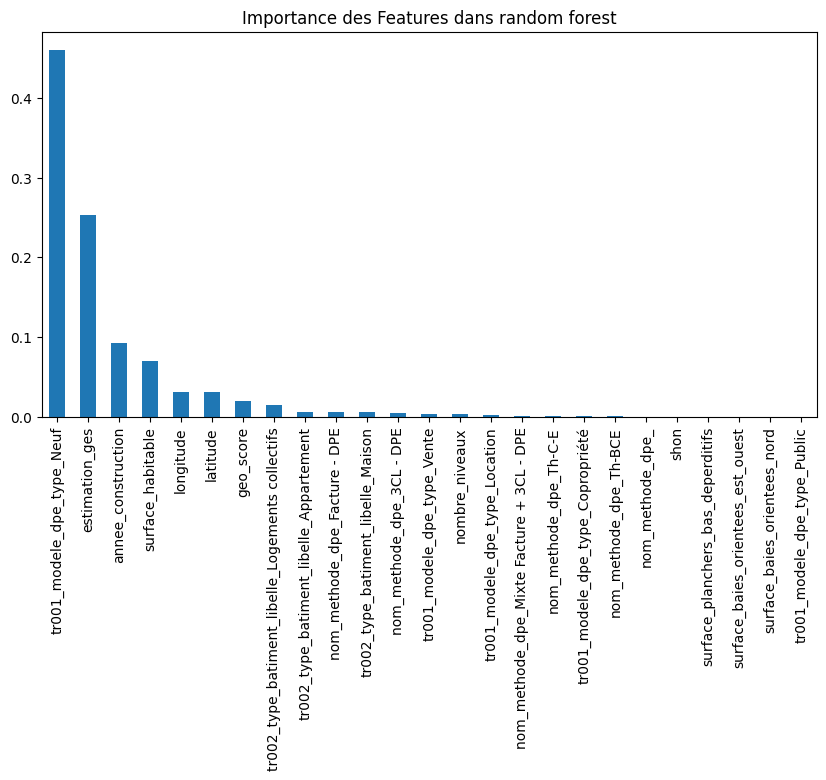

In [432]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importance des Features dans random forest")
plt.show()

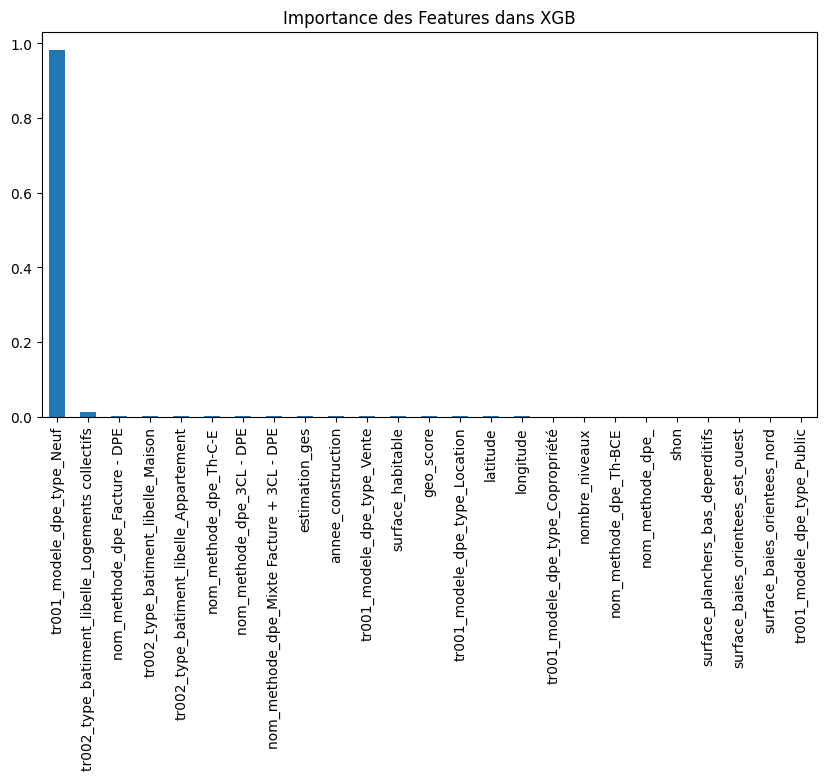

In [433]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importance des Features dans XGB")
plt.show()

In [427]:
from lightgbm import LGBMRegressor

# Initialiser LightGBM
lgbm_model = LGBMRegressor(n_estimators=3000, max_depth=100, learning_rate=0.04278, random_state=42, subsample=0.69)

# Entraîner le modèle
lgbm_model.fit(X_train, y_train)

# Prédictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Évaluation
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"✅ Performance du modèle LightGBM :")
print(f"MAE: {mae_lgbm:.2f}, MSE: {mse_lgbm:.2f}, R²: {r2_lgbm:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 19
[LightGBM] [Info] Start training from score 179.208486
✅ Performance du modèle LightGBM :
MAE: 16.33, MSE: 1048.10, R²: 0.89


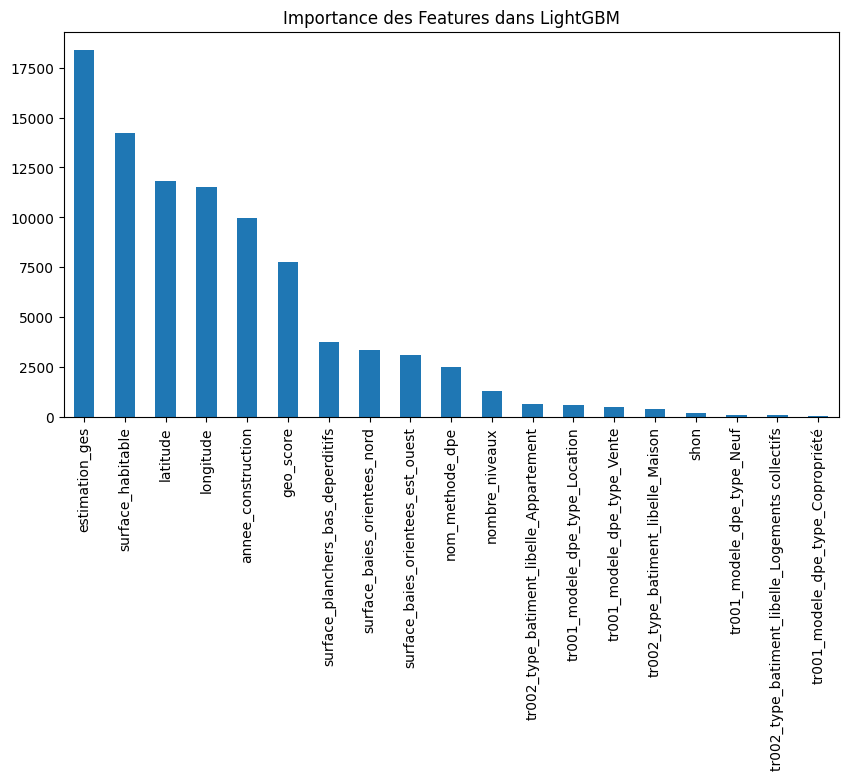

In [179]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = pd.Series(lgbm_model.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Importance des Features dans LightGBM")
plt.show()

In [361]:
from sklearn.svm import SVR

# Initialiser SVR avec kernel RBF
svr_model = SVR(kernel='rbf', C=150, gamma=0.1, epsilon=0.1)

# Entraîner le modèle
svr_model.fit(X_train, y_train)

# Prédictions
y_pred_svr = svr_model.predict(X_test)

# Évaluation
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"✅ Performance du modèle SVR :")
print(f"MAE: {mae_svr:.2f}, MSE: {mse_svr:.2f}, R²: {r2_svr:.2f}")

✅ Performance du modèle SVR :
MAE: 45.34, MSE: 5671.36, R²: 0.49


In [292]:
# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Performance du modèle :")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

📊 Performance du modèle :
MAE: 29.10, MSE: 3343.04, R²: 0.70


In [197]:
from sklearn.model_selection import train_test_split

# Séparer les données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (56651, 18), Test size: (14163, 18)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vérification
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialiser et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Performance du modèle :")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


📊 Performance du modèle :
MAE: 69.66, MSE: 8509.86, R²: 0.20


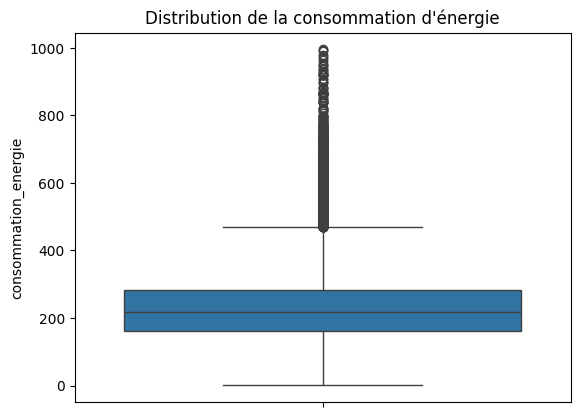

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=y_train)
plt.title("Distribution de la consommation d'énergie")
plt.show()


In [118]:
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

# Filtrage des valeurs extrêmes
y_train_filtered = y_train[(y_train >= Q1 - 1.5 * IQR) & (y_train <= Q3 + 1.5 * IQR)]
X_train_filtered = X_train.loc[y_train_filtered.index]


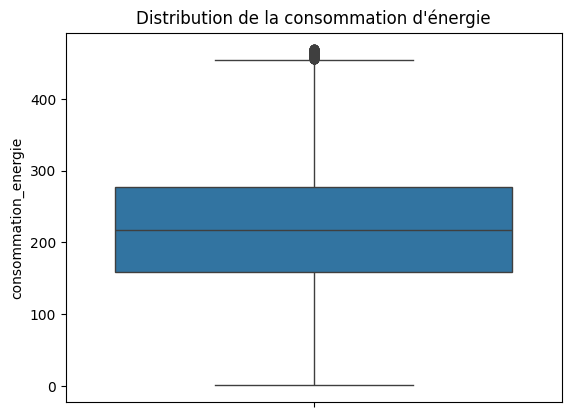

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=y_train_filtered)
plt.title("Distribution de la consommation d'énergie")
plt.show()

In [201]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Entraîner un Random Forest pour voir l'importance des features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Récupérer l'importance des features
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Afficher les features importantes
print(feature_importance)


                                             Feature  Importance
0                                     estimation_ges    0.350804
1                                 annee_construction    0.229212
2                                  surface_habitable    0.130362
8                                          longitude    0.075119
9                                           latitude    0.070035
10                                         geo_score    0.037230
4                                     nombre_niveaux    0.020139
7                  surface_planchers_bas_deperditifs    0.019681
12                                   nom_methode_dpe    0.015724
6                  surface_baies_orientees_est_ouest    0.014199
5                       surface_baies_orientees_nord    0.013583
11                               portee_dpe_batiment    0.007774
17                tr002_type_batiment_libelle_Maison    0.004246
13                    tr001_modele_dpe_type_Location    0.003055
15                       

In [200]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Entraîner un Random Forest pour voir l'importance des features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_filtered, y_train_filtered)

# Récupérer l'importance des features
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Afficher les features importantes
print(feature_importance)


NameError: name 'X_train_filtered' is not defined

In [199]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Évaluer la performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"📊 Performance du modèle Random Forest :")
print(f"MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


📊 Performance du modèle Random Forest :
MAE: 30.17, MSE: 3458.01, R²: 0.67


In [150]:
# Prédiction sur les données de test
y_pred_rf = rf_model.predict(X_test)

# Comparer les prédictions avec les vraies valeurs
import pandas as pd

test_results = pd.DataFrame({
    "Valeur Réelle": y_test,
    "Prédiction": y_pred_rf
})

# Afficher les premières lignes
print(test_results.head(10))

# Sauvegarder pour analyse
test_results.to_excel("test_results.xlsx", index=False)

       Valeur Réelle  Prédiction
48156         111.56  152.907167
65181         226.00  245.979500
38228         302.37  286.513600
44702         316.70  253.465033
36471         237.55  237.550000
62976         181.71  233.686300
44102         118.00  368.127800
22917         382.66  347.418767
28997         132.75  150.114533
2990          225.82  224.737000


In [135]:
import numpy as np

# Appliquer une transformation log à la variable cible
y_train_log = np.log1p(y_train_filtered)  # log(1 + x) pour éviter log(0)
y_test_log = np.log1p(y_test)

# Entraîner un modèle avec y_log au lieu de y
rf_model.fit(X_train_filtered, y_train_log)

# Prédiction et re-transformation
y_pred_log = rf_model.predict(X_test)
y_pred_original_scale = np.expm1(y_pred_log)  # Annule la transformation log

# Évaluation du modèle
mae_log = mean_absolute_error(y_test, y_pred_original_scale)
print(f"📊 MAE après transformation log : {mae_log:.2f}")

📊 MAE après transformation log : 30.84


In [136]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialiser le modèle XGBoost
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train_filtered, y_train_filtered)

# Prédire sur les données de test
y_pred_xgb = xgb_model.predict(X_test)

# Évaluer les performances
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"📊 Performance du modèle XGBoost :")
print(f"MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")

📊 Performance du modèle XGBoost :
MAE: 30.72, MSE: 4647.30, R²: 0.58


In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Définir une grille de paramètres
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_filtered, y_train_filtered)

# Meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)

# Réentraîner avec les meilleurs paramètres
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)

# Évaluer le modèle optimisé
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
print(f"📊 MAE après optimisation de Random Forest : {mae_optimized:.2f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

In [209]:
%pip install scikit-learn-intelex

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ------ --------------------------------- 0.5/3.2 MB 3.3 MB/s eta 0:00:01
   --------- ------------------------------ 0.8/3.2 MB 2.2 MB/s eta 0:00:02
   ---------------- ----------------------- 1.3/3.2 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 1.6/3.2 MB 1.9 MB/s eta 0:00:01
   ---------------------- ----------------- 1.8/3.2 MB 1.8 MB/s eta 0:00:01
   ------------------------- -------------- 2.1/3.2 MB 1.7 MB/s eta 0:00:01
   ----------------------------- ---------- 2.4/3.2 MB 1.6 MB/s eta 0:00:01
   ----------------------------- ---------- 2.4/3.2 MB 1.6 MB/s eta 0:00:01
   -------------------------------- ------- 2.6/3.2 MB 1.5 MB/s eta 0:00:01
   --------------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\tarek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [211]:
%pip install sklearnex

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearnex (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\tarek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for sklearnex


In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Liste des features importantes
important_features = [
    "estimation_ges",
    "annee_construction",
    "surface_habitable",
    "longitude",
    "latitude"
]

# Sélectionner uniquement ces features dans les datasets
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

# Entraîner le modèle avec les features sélectionnées
rf_model = RandomForestRegressor(n_estimators=700, random_state=42)
rf_model.fit(X_train_selected, y_train)
y_pred_rf = rf_model.predict(X_test_selected)

# Évaluer la performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"📊 Performance du modèle avec NPU optimisé (Intel Extension) :")
print(f"MAE: {mae_rf:.2f}, MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")


📊 Performance du modèle avec NPU optimisé (Intel Extension) :
MAE: 30.21, MSE: 3586.79, R²: 0.66


In [208]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Liste des features importantes (choisis ton seuil, ici 0.05)
important_features = [
    "estimation_ges",
    "annee_construction",
    "surface_habitable",
    "longitude",
    "latitude",
]

# Sélectionner uniquement ces features dans les datasets
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]



# ✅ Réduction de la grille pour aller plus vite (~30 min max)
param_grid = {
    'n_estimators': [1100],  # Réduit à 3 valeurs au lieu de 4
    'max_depth': [None],  # Réduit à 3 valeurs au lieu de 4
    'min_samples_split': [2],  # Réduit à 2 valeurs au lieu de 3
    'min_samples_leaf': [2]  # Réduit à 2 valeurs au lieu de 3
}  # 3 × 3 × 2 × 2 = **36 combinaisons**, au lieu de 144

# ✅ Initialisation du modèle
rf = RandomForestRegressor(random_state=42)

# ✅ Utilisation de RandomizedSearchCV pour accélérer la recherche (20 tests aléatoires max)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Teste seulement 20 combinaisons aléatoires
    cv=2,  # Réduit la validation croisée (3 folds au lieu de 5)
    n_jobs=-1,  # Utilisation de tous les cœurs du processeur
    verbose=2,
    random_state=42
)

# ✅ Entraînement
random_search.fit(X_train_selected, y_train)

# ✅ Meilleurs hyperparamètres trouvés
print("Meilleurs paramètres:", random_search.best_params_)

# ✅ Réentraîner le modèle avec les meilleurs paramètres
best_rf = random_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test_selected)

# ✅ Évaluation du modèle optimisé
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"📊 Performance après optimisation :")
print(f"MAE: {mae_optimized:.2f}, MSE: {mse_optimized:.2f}, R²: {r2_optimized:.2f}")

C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Meilleurs paramètres: {'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
📊 Performance après optimisation :
MAE: 30.12, MSE: 3548.26, R²: 0.66


In [152]:
%pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ----------------------------- ---------- 1.0/1.4 MB 1.5 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\tarek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [206]:
merged_data

,estimation_ges,annee_construction,surface_habitable,shon,nombre_niveaux,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_planchers_bas_deperditifs,longitude,latitude,geo_score,consommation_energie,portee_dpe_batiment,nom_methode_dpe,tr001_modele_dpe_type_Location,tr001_modele_dpe_type_Neuf,tr001_modele_dpe_type_Vente,tr002_type_batiment_libelle_Logements collectifs,tr002_type_batiment_libelle_Maison
0,-0.806292,0.831187,-0.020184,-0.074996,0.193557,-0.180363,-0.186187,-0.418002,-0.152946,0.551334,-1.630916,209.64,-0.340053,13,0,0,1,0,1
1,-0.970402,-1.767261,-0.301956,-0.074996,-0.726345,-0.180363,-0.186187,-0.418002,-0.423808,-0.076627,0.924883,177.12,3.796074,1,1,0,0,0,0
2,1.496653,-0.223628,-0.211271,-0.074996,0.193557,-0.180363,-0.186187,-0.418002,-0.472690,0.011100,-0.394239,361.30,-0.340053,13,0,0,1,0,1
3,-0.201087,0.651097,0.278429,-0.074996,-0.726345,-0.180363,-0.186187,-0.418002,-0.091558,0.182423,-1.630916,103.60,3.796074,1,0,0,1,0,1
4,-0.364363,-1.767261,-0.360901,-0.074996,-0.726345,-0.180363,-0.186187,-0.418002,-0.427165,-0.065521,0.924883,624.19,3.796074,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70809,0.275413,-0.352265,-0.110869,-0.074996,0.193557,-0.180363,-0.186187,-0.418002,-0.429069,-0.203537,0.430213,218.35,-0.340053,8,0,0,1,0,1
70810,-0.143607,0.548188,0.034875,-0.074996,0.193557,-0.180363,-0.186187,-0.418002,-0.620295,-0.559975,-1.301135,109.50,-0.340053,9,0,0,1,0,1
70811,-0.896677,-0.995445,0.069886,-0.074996,-0.726345,-0.180363,-0.186187,-0.418002,0.014770,-1.734605,0.759993,231.68,-0.340053,8,0,0,1,0,0
70812,-0.544300,0.368097,0.122321,-0.074996,0.193557,-0.180363,0.335844,0.954678,-0.890057,-1.601102,-0.847687,273.00,-0.340053,8,0,0,1,0,1


In [207]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Charger les données (remplace par ton fichier)
df = merged_data

# ✅ Vérifier et nettoyer les noms de colonnes
df.columns = df.columns.str.replace(" ", "_")

# ✅ Séparer les features (X) et la cible (y)
X = df.drop(columns=["consommation_energie"])  # Remplace par ta variable cible
y = df["consommation_energie"]

# ✅ Séparer les données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Séparer validation (20% du train)
X_train_light, X_val, y_train_light, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# ✅ Initialiser le modèle LightGBM
lgb_model = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=31,  # Nombre de feuilles max par arbre
    learning_rate=0.05,  # Taux d'apprentissage
    n_estimators=1000,  # Nombre max d'itérations
    max_depth=-1,  # Profondeur illimitée
    subsample=0.8,  # Échantillonnage des lignes
    colsample_bytree=0.8,  # Échantillonnage des colonnes
    random_state=42,
    n_jobs=-1,  # Utilisation maximale des cœurs CPU
)

# ✅ Entraîner le modèle avec Early Stopping
lgb_model.fit(
    X_train_light, y_train_light,
    eval_set=[(X_val, y_val)],  # Set de validation
    eval_metric="l1",  # MAE (Mean Absolute Error)
    callbacks=[lgb.early_stopping(50, verbose=True)]  # Arrêt après 50 itérations sans amélioration
)

# ✅ Prédictions sur le jeu de test
y_pred_lgb = lgb_model.predict(X_test)

# ✅ Calcul des métriques d'évaluation
mae = mean_absolute_error(y_test, y_pred_lgb)
mse = mean_squared_error(y_test, y_pred_lgb)
r2 = r2_score(y_test, y_pred_lgb)

# ✅ Affichage des performances
print(f"📊 Performance du modèle LightGBM :")
print(f"MAE : {mae:.2f}")
print(f"MSE : {mse:.2f}")
print(f"R² : {r2:.2f}")

# ✅ Afficher les 10 premières prédictions
df_results = pd.DataFrame({"Valeur Réelle": y_test.values, "Prédiction": y_pred_lgb})
print(df_results.head(10))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 45320, number of used features: 18
[LightGBM] [Info] Start training from score 227.506238
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l1: 34.1015	valid_0's l2: 3773.26
📊 Performance du modèle LightGBM :
MAE : 33.18
MSE : 3546.88
R² : 0.66
   Valeur Réelle  Prédiction
0         236.08  219.544729
1         198.48  197.163777
2         515.06  252.537302
3         218.84  222.473384
4         256.00  277.949770
5         270.85  268.085288
6         289.00  275.344969
7         351.20  396.947923
8         208.34  221.800474
9          52.39   58.527664


In [ ]:
%pip install optuna

In [382]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }

    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_opt, y_train_opt, eval_set=[(X_val_opt, y_val_opt)], eval_metric="l1")

    y_pred_opt = model.predict(X_val_opt)
    return mean_absolute_error(y_val_opt, y_pred_opt)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("✅ Meilleurs hyperparamètres :", best_params)


C:\Users\tarek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-12 11:26:49,808] A new study created in memory with name: no-name-f66611a4-5aee-485a-94aa-4e46c8f62a5a
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:26:54,279] Trial 0 finished with value: 31.375172856378033 and parameters: {'num_leaves': 63, 'learning_rate': 0.013017547224493864, 'n_estimators': 1054, 'subsample': 0.7165501610856402, 'colsample_bytree': 0.5153283041952306}. Best is trial 0 with value: 31.375172856378033.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_277

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:26:58,669] Trial 1 finished with value: 31.201486402011696 and parameters: {'num_leaves': 57, 'learning_rate': 0.011358192517836771, 'n_estimators': 1186, 'subsample': 0.774797244288723, 'colsample_bytree': 0.5840452918351446}. Best is trial 1 with value: 31.201486402011696.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2770

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:02,297] Trial 2 finished with value: 29.671602888323076 and parameters: {'num_leaves': 40, 'learning_rate': 0.026823974615742742, 'n_estimators': 1373, 'subsample': 0.5703535663406198, 'colsample_bytree': 0.9146115372374979}. Best is trial 2 with value: 29.671602888323076.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_277

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:05,120] Trial 3 finished with value: 29.915227827569904 and parameters: {'num_leaves': 36, 'learning_rate': 0.03645393611633165, 'n_estimators': 1148, 'subsample': 0.937551983297537, 'colsample_bytree': 0.7100727152430584}. Best is trial 2 with value: 29.671602888323076.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:09,988] Trial 4 finished with value: 28.344353145663412 and parameters: {'num_leaves': 57, 'learning_rate': 0.03889864742679596, 'n_estimators': 1546, 'subsample': 0.9702225138824958, 'colsample_bytree': 0.8743424335121539}. Best is trial 4 with value: 28.344353145663412.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2770

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:16,596] Trial 5 finished with value: 28.56592967513861 and parameters: {'num_leaves': 78, 'learning_rate': 0.08587615533004637, 'n_estimators': 1716, 'subsample': 0.8902596091110169, 'colsample_bytree': 0.6022827697271296}. Best is trial 4 with value: 28.344353145663412.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:20,212] Trial 6 finished with value: 30.138843385098163 and parameters: {'num_leaves': 36, 'learning_rate': 0.02653516617129722, 'n_estimators': 1476, 'subsample': 0.8215743081920195, 'colsample_bytree': 0.6566834793775482}. Best is trial 4 with value: 28.344353145663412.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2770

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:26,408] Trial 7 finished with value: 28.032013958061953 and parameters: {'num_leaves': 88, 'learning_rate': 0.03438660866489524, 'n_estimators': 1426, 'subsample': 0.6376929152451571, 'colsample_bytree': 0.8553300662609158}. Best is trial 7 with value: 28.032013958061953.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2770

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:30,056] Trial 8 finished with value: 28.88098840708765 and parameters: {'num_leaves': 33, 'learning_rate': 0.05755713408928151, 'n_estimators': 1696, 'subsample': 0.6873855445687185, 'colsample_bytree': 0.8554509071766159}. Best is trial 7 with value: 28.032013958061953.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:34,050] Trial 9 finished with value: 28.44011947271087 and parameters: {'num_leaves': 69, 'learning_rate': 0.03665568983791863, 'n_estimators': 1056, 'subsample': 0.9669069711910099, 'colsample_bytree': 0.9228811631022522}. Best is trial 7 with value: 28.032013958061953.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:37,148] Trial 10 finished with value: 29.369997232832493 and parameters: {'num_leaves': 98, 'learning_rate': 0.017668168533392016, 'n_estimators': 526, 'subsample': 0.5229265778909226, 'colsample_bytree': 0.9995975433751749}. Best is trial 7 with value: 28.032013958061953.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_277

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:45,632] Trial 11 finished with value: 27.774846005936 and parameters: {'num_leaves': 92, 'learning_rate': 0.05214654751949284, 'n_estimators': 1953, 'subsample': 0.6216828180687104, 'colsample_bytree': 0.8086365098781612}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\58

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:27:54,840] Trial 12 finished with value: 27.784302930942697 and parameters: {'num_leaves': 100, 'learning_rate': 0.05993011219330798, 'n_estimators': 1978, 'subsample': 0.6315255034493936, 'colsample_bytree': 0.7854119869920224}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2770

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:03,739] Trial 13 finished with value: 28.022349979110338 and parameters: {'num_leaves': 96, 'learning_rate': 0.06517877261913703, 'n_estimators': 1993, 'subsample': 0.6175855214170256, 'colsample_bytree': 0.7634258243058301}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:12,008] Trial 14 finished with value: 27.842017540701583 and parameters: {'num_leaves': 84, 'learning_rate': 0.05709912567960081, 'n_estimators': 1989, 'subsample': 0.5026467837493324, 'colsample_bytree': 0.7673261983083333}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:20,710] Trial 15 finished with value: 28.193505005972245 and parameters: {'num_leaves': 100, 'learning_rate': 0.095716581312341, 'n_estimators': 1838, 'subsample': 0.6467236826780344, 'colsample_bytree': 0.8166917387282397}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:24,584] Trial 16 finished with value: 28.503531151280193 and parameters: {'num_leaves': 77, 'learning_rate': 0.045715467716450256, 'n_estimators': 811, 'subsample': 0.5858327084014023, 'colsample_bytree': 0.7180982888496399}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:33,711] Trial 17 finished with value: 27.937674500651276 and parameters: {'num_leaves': 88, 'learning_rate': 0.07051232189924866, 'n_estimators': 1802, 'subsample': 0.7508412219569014, 'colsample_bytree': 0.7978607927629948}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:37,185] Trial 18 finished with value: 30.518330291104874 and parameters: {'num_leaves': 20, 'learning_rate': 0.04957898509617208, 'n_estimators': 1639, 'subsample': 0.668236189190421, 'colsample_bytree': 0.6707650328760049}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:46,766] Trial 19 finished with value: 27.95842766988595 and parameters: {'num_leaves': 92, 'learning_rate': 0.07872627171961169, 'n_estimators': 1885, 'subsample': 0.5563139042736001, 'colsample_bytree': 0.9786066939739126}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:50,661] Trial 20 finished with value: 29.518856157321988 and parameters: {'num_leaves': 75, 'learning_rate': 0.020991723033796844, 'n_estimators': 810, 'subsample': 0.8215367678552645, 'colsample_bytree': 0.8106123312806329}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:28:59,745] Trial 21 finished with value: 27.930070172562026 and parameters: {'num_leaves': 85, 'learning_rate': 0.05383671566946253, 'n_estimators': 1946, 'subsample': 0.5028754997410936, 'colsample_bytree': 0.7588809685705019}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:08,508] Trial 22 finished with value: 28.04050773805211 and parameters: {'num_leaves': 82, 'learning_rate': 0.0612348739096634, 'n_estimators': 1972, 'subsample': 0.6049602366471429, 'colsample_bytree': 0.727651322924728}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\58

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:17,642] Trial 23 finished with value: 27.823537720688776 and parameters: {'num_leaves': 92, 'learning_rate': 0.04423162012611599, 'n_estimators': 1796, 'subsample': 0.5392658471885203, 'colsample_bytree': 0.7900061291424191}. Best is trial 11 with value: 27.774846005936.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:27,058] Trial 24 finished with value: 27.64272923464193 and parameters: {'num_leaves': 92, 'learning_rate': 0.04264552922372355, 'n_estimators': 1794, 'subsample': 0.551026132491682, 'colsample_bytree': 0.8950228741400962}. Best is trial 24 with value: 27.64272923464193.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:35,716] Trial 25 finished with value: 27.491684013128143 and parameters: {'num_leaves': 100, 'learning_rate': 0.04265938059432768, 'n_estimators': 1583, 'subsample': 0.6978157657167925, 'colsample_bytree': 0.9388761643014829}. Best is trial 25 with value: 27.491684013128143.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:44,642] Trial 26 finished with value: 27.82679255399172 and parameters: {'num_leaves': 93, 'learning_rate': 0.029879028186684673, 'n_estimators': 1606, 'subsample': 0.7046243305417075, 'colsample_bytree': 0.9479444127016868}. Best is trial 25 with value: 27.491684013128143.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:51,135] Trial 27 finished with value: 28.215162755917 and parameters: {'num_leaves': 68, 'learning_rate': 0.04321906765985946, 'n_estimators': 1299, 'subsample': 0.7244932703926735, 'colsample_bytree': 0.8944758819655879}. Best is trial 25 with value: 27.491684013128143.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:29:57,390] Trial 28 finished with value: 28.949043700791375 and parameters: {'num_leaves': 47, 'learning_rate': 0.030016319373608352, 'n_estimators': 1523, 'subsample': 0.6675325678303066, 'colsample_bytree': 0.9557152514820738}. Best is trial 25 with value: 27.491684013128143.
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\tarek\AppData\Local\Temp\ipykernel_27708\584330082.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\tarek\AppData\Local\Temp\ipykernel_2

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 77046, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 205.784895


[I 2025-02-12 11:30:07,287] Trial 29 finished with value: 28.6197126048782 and parameters: {'num_leaves': 69, 'learning_rate': 0.020673848976266493, 'n_estimators': 1734, 'subsample': 0.5811061788499747, 'colsample_bytree': 0.8369706098786683}. Best is trial 25 with value: 27.491684013128143.


✅ Meilleurs hyperparamètres : {'num_leaves': 100, 'learning_rate': 0.04265938059432768, 'n_estimators': 1583, 'subsample': 0.6978157657167925, 'colsample_bytree': 0.9388761643014829}


In [381]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Créer un pipeline pour transformer les features en polynômes (degré 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Entraîner le modèle
poly_model.fit(X_train, y_train)

# Prédire sur les données de test
y_pred_poly = poly_model.predict(X_test)

# Évaluer le modèle
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"📊 Performance du modèle polynomiale (degré 2) :")
print(f"MAE: {mae_poly:.2f}, MSE: {mse_poly:.2f}, R²: {r2_poly:.2f}")

📊 Performance du modèle polynomiale (degré 2) :
MAE: 53.21, MSE: 6841.27, R²: 0.47
